In [3]:
import pandas as pd
import pyarrow.parquet as pq

# --- 1. Define Our Attack Rules ---
attack_event_names = [
    'GetBucketAcl',
    'ListBuckets',
    'DescribeSnapshots',
    'AssumeRole',
    'GetUser',
    'ListRolePolicies',
    'GetRolePolicy',
    'ListAttachedRolePolicies'
]
print(f"Defined {len(attack_event_names)} event names as 'Known Attack Patterns'.")

# --- 2. Define Columns to Read ---
columns_to_read = [
    'eventTime',
    'event_name', # This column must exist (from previous feature engineering)
    'sourceIPAddress',
    'userIdentity.arn',
    'anomaly_label' # The label from Isolation Forest
]

# --- 3. Process Data Incrementally (Memory-Safe) ---
parquet_file = 'labeled_dataset.parquet'
known_attack_events = [] # A list to hold the rows that match our rules

print(f"Reading '{parquet_file}' to find events matching attack rules...")

try:
    parquet_reader = pq.ParquetFile(parquet_file)
    num_row_groups = parquet_reader.num_row_groups

    for i in range(num_row_groups):
        print(f"  - Processing row group {i+1}/{num_row_groups}...")
        
        # Read *only* the specific columns we need
        table = parquet_reader.read_row_group(i, columns=columns_to_read)
        
        chunk_df = table.to_pandas()

        # --- 4. Apply the Rules ---
        # Find all rows in this chunk where the 'event_name' is in our list
        matches = chunk_df[chunk_df['event_name'].isin(attack_event_names)]
        
        if not matches.empty:
            known_attack_events.append(matches)

    # --- 5. Create the Final "Ground Truth" DataFrame ---
    if known_attack_events:
        df_ground_truth_malicious = pd.concat(known_attack_events, ignore_index=True)
        
        print("\n--- Ground Truth Analysis Complete ---")
        print(f"Found {len(df_ground_truth_malicious)} events matching known attack patterns.")
        
        print("\n--- Event Types Found ---")
        print(df_ground_truth_malicious['event_name'].value_counts())
        
        print("\n--- Comparison with Anomaly Label ---")
        # Show percentage of "Known Attack" events flagged as Normal/Anomaly
        print(df_ground_truth_malicious['anomaly_label'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')
    
        print("\n--- Sample of Ground Truth Malicious Events ---")
        # Use print() instead of display() for guaranteed output
        print(df_ground_truth_malicious.head())
        
        # --- FIX: Corrected the unterminated string literal ---
        df_ground_truth_malicious.to_csv('ground_truth_attack_events.csv', index=False)
        print("\nSaved this list to 'ground_truth_attack_events.csv'")
        
    else:
        print("No events found matching the defined attack rules.")

except Exception as e:
    print(f"\nAn error occurred. Did you run the 'Dataset.ipynb' notebook to create 'labeled_dataset.parquet'?")
    print(f"Error details: {e}")

Defined 8 event names as 'Known Attack Patterns'.
Reading 'labeled_dataset.parquet' to find events matching attack rules...
  - Processing row group 1/2...
  - Processing row group 2/2...

--- Ground Truth Analysis Complete ---
Found 243803 events matching known attack patterns.

--- Event Types Found ---
event_name
DescribeSnapshots           102510
AssumeRole                   79322
GetBucketAcl                 42651
ListBuckets                  13362
GetUser                       3478
ListRolePolicies              1433
ListAttachedRolePolicies       683
GetRolePolicy                  364
Name: count, dtype: int64

--- Comparison with Anomaly Label ---
anomaly_label
Normal     94.59%
Anomaly     5.41%
Name: proportion, dtype: object

--- Sample of Ground Truth Malicious Events ---
                  eventTime         event_name  sourceIPAddress  \
0 2017-02-12 19:57:06+00:00        ListBuckets  255.253.125.115   
1 2017-02-12 20:02:35+00:00        ListBuckets     AWS Internal   
2 201

In [5]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# --- 1. Configuration ---
csv_file = 'ground_truth_attack_events.csv'
CHUNK_SIZE = 50000  # Process 50,000 events per chunk

# Columns we need
ip_col = 'sourceIPAddress'
arn_col = 'userIdentity.arn'
event_col = 'event_name'
time_col = 'eventTime'

# --- 2. Initialize the Attack Graph ---
G_attack = nx.DiGraph()
print("Initialized an empty Directed Graph for the 'Attack Graph'.")

# --- 3. Process the CSV File in Chunks ---
print(f"Reading '{csv_file}' in chunks of {CHUNK_SIZE}...")

total_rows = 0

# Create an iterator to read the CSV chunk by chunk
csv_iterator = pd.read_csv(csv_file, chunksize=CHUNK_SIZE, parse_dates=[time_col])

for chunk_df in csv_iterator:
    total_rows += len(chunk_df)
    print(f"  - Processing chunk ({len(chunk_df)} rows)...")

    # --- THIS IS THE FIX ---
    # Iterate using .to_dict('records') which handles column names with '.'
    for row in chunk_df.to_dict('records'):
        ip = row.get(ip_col)
        arn = row.get(arn_col)
        event = row.get(event_col, 'Unknown Event')
        timestamp = row.get(time_col)

        # Add nodes with 'type' attribute
        if ip and not G_attack.has_node(ip):
            G_attack.add_node(ip, type='IP')
        if arn and not G_attack.has_node(arn):
            G_attack.add_node(arn, type='ARN')

        # Add a directed edge from IP to ARN
        if ip and arn:
            # Add edge with event and timestamp
            G_attack.add_edge(ip, arn, event=event, timestamp=timestamp)

print(f"\nFinished processing {total_rows} attack events.")
print(f"Attack Graph built with {G_attack.number_of_nodes()} nodes and {G_attack.number_of_edges()} edges.")

# --- 4. Basic Graph Info ---
print("\n--- Attack Graph Information ---")
node_types = pd.Series(nx.get_node_attributes(G_attack, 'type')).value_counts()
print("Node Types:\n", node_types)

# --- 5. Analyze the Attack Graph ---
print("\n--- Top 10 Most Active Attacker IPs (by connections) ---")
ip_nodes = [n for n, d in G_attack.nodes(data=True) if d.get('type') == 'IP']
# Get out_degree (number of actions initiated) for IP nodes only
ip_out_degrees = G_attack.out_degree(ip_nodes)
# Sort and print the top 10
top_attackers = sorted(ip_out_degrees, key=lambda x: x[1], reverse=True)[:10]
for ip, degree in top_attackers:
    print(f"  - IP: {ip}, Actions: {degree}")

print("\n--- Top 10 Most Targeted ARNs ---")
arn_nodes = [n for n, d in G_attack.nodes(data=True) if d.get('type') == 'ARN']
# Get in_degree (number of actions targeting them) for ARN nodes only
arn_in_degrees = G_attack.in_degree(arn_nodes)
# Sort and print the top 10
top_targets = sorted(arn_in_degrees, key=lambda x: x[1], reverse=True)[:10]
for arn, degree in top_targets:
    print(f"  - ARN: {arn}, Targeted by: {degree} distinct actors")

Initialized an empty Directed Graph for the 'Attack Graph'.
Reading 'ground_truth_attack_events.csv' in chunks of 50000...
  - Processing chunk (50000 rows)...
  - Processing chunk (50000 rows)...
  - Processing chunk (50000 rows)...
  - Processing chunk (50000 rows)...
  - Processing chunk (43803 rows)...

Finished processing 243803 attack events.
Attack Graph built with 4821 nodes and 6689 edges.

--- Attack Graph Information ---
Node Types:
 IP     4791
ARN      30
Name: count, dtype: int64

--- Top 10 Most Active Attacker IPs (by connections) ---
  - IP: 250.251.253.3, Actions: 18
  - IP: 255.253.125.115, Actions: 10
  - IP: 60.219.252.71, Actions: 5
  - IP: 252.138.62.6, Actions: 4
  - IP: 234.230.30.247, Actions: 4
  - IP: 47.218.131.16, Actions: 4
  - IP: 178.6.253.250, Actions: 4
  - IP: 251.226.255.250, Actions: 4
  - IP: 67.254.143.9, Actions: 4
  - IP: 86.1.86.209, Actions: 4

--- Top 10 Most Targeted ARNs ---
  - ARN: arn:aws:iam::811596193553:user/backup, Targeted by: 4330

Found 18 direct neighbors for 250.251.253.3.
Subgraph created with 19 nodes and 18 edges.
Subgraph visualization saved to attack_neighborhood_250.251.253.3.png


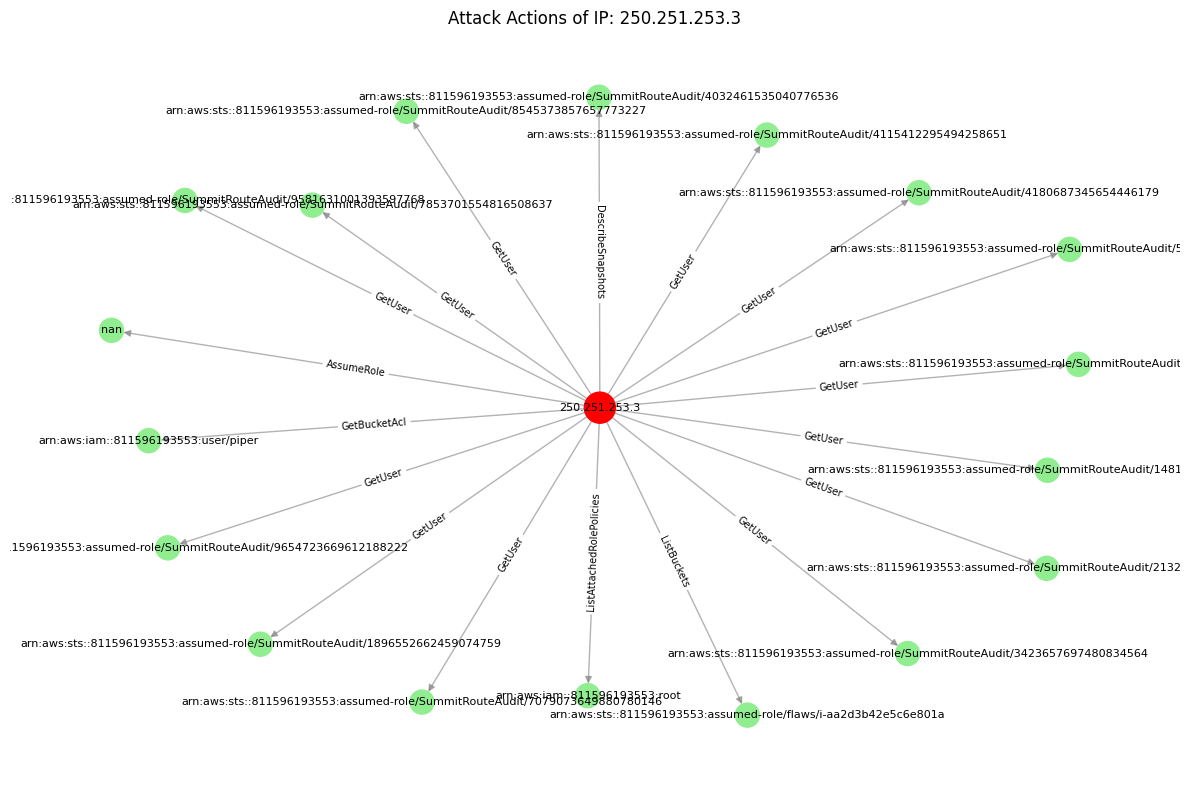

In [6]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Assume 'G_attack' is your attack graph object already loaded in memory.

# --- Step 1: Define the Target Node ---
target_node = '250.251.253.3' # The most active attacker

if target_node not in G_attack:
    print(f"Error: Target node {target_node} not found in the graph 'G_attack'.")
else:
    # --- Step 2: Get Neighbors ---
    # Find all nodes directly connected to the target node
    neighbors = list(nx.neighbors(G_attack, target_node))
    nodes_in_subgraph = [target_node] + neighbors
    print(f"Found {len(neighbors)} direct neighbors for {target_node}.")

    # --- Step 3: Create the Subgraph ---
    subgraph = G_attack.subgraph(nodes_in_subgraph)
    print(f"Subgraph created with {subgraph.number_of_nodes()} nodes and {subgraph.number_of_edges()} edges.")

    # --- Step 4: Visualize the Subgraph ---
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(subgraph, seed=42) # Use a seed for consistent layout

    # Define node colors and sizes
    node_colors = []
    node_sizes = []
    for node in subgraph.nodes():
        if node == target_node:
            node_colors.append('red') # Highlight the central attacker
            node_sizes.append(500)
        elif G_attack.nodes[node].get('type') == 'ARN':
            node_colors.append('lightgreen') # Color for ARNs
            node_sizes.append(300)
        else: # Other IPs
            node_colors.append('skyblue')
            node_sizes.append(200)

    # Draw the graph components
    nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=node_sizes)
    nx.draw_networkx_edges(subgraph, pos, edge_color='gray', alpha=0.6, arrows=True)
    nx.draw_networkx_labels(subgraph, pos, font_size=8) # Label all nodes

    # Add edge labels (event names)
    edge_labels = nx.get_edge_attributes(subgraph, 'event')
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=7)

    plt.title(f"Attack Actions of IP: {target_node}")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"attack_neighborhood_{target_node}.png")
    print(f"Subgraph visualization saved to attack_neighborhood_{target_node}.png")

In [8]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np

# --- 1. Load the "Malicious" dataset ---
malicious_csv = 'ground_truth_attack_events.csv'
print(f"Loading 'Malicious' events from {malicious_csv}...")

# Ensure correct columns are loaded
malicious_cols_to_load = ['eventTime', 'event_name', 'sourceIPAddress', 'userIdentity.arn', 'anomaly_label']
df_malicious = pd.read_csv(malicious_csv, usecols=malicious_cols_to_load)
df_malicious['label'] = 1 # 1 = Malicious
n_malicious = len(df_malicious)
print(f"Loaded {n_malicious} malicious events.")

# --- 2. Define Attack Rules (to filter them out) ---
attack_event_names = list(df_malicious['event_name'].unique())

# --- 3. Sample "Benign" events from the main dataset ---
parquet_file = 'labeled_dataset.parquet'
benign_samples_needed = n_malicious
benign_events_list = [] # <-- This is the correct list name

print(f"Reading '{parquet_file}' to sample {benign_samples_needed} benign events...")
parquet_reader = pq.ParquetFile(parquet_file)
num_row_groups = parquet_reader.num_row_groups

# We need the same columns as the malicious CSV
columns_to_read = ['eventTime', 'event_name', 'sourceIPAddress', 'userIdentity.arn', 'anomaly_label']

for i in range(num_row_groups):
    if benign_samples_needed <= 0:
        break # We have enough samples
        
    print(f"  - Processing row group {i+1}/{num_row_groups}...")
    table = parquet_reader.read_row_group(i, columns=columns_to_read)
    chunk_df = table.to_pandas()
    
    # Filter out rows that are in our "Malicious" list
    benign_chunk = chunk_df[~chunk_df['event_name'].isin(attack_event_names)]
    
    if not benign_chunk.empty:
        # If this chunk has more benign events than we need, sample and finish
        if len(benign_chunk) >= benign_samples_needed:
            # --- THIS IS THE FIX ---
            benign_events_list.append(benign_chunk.sample(n=benign_samples_needed, random_state=42))
            benign_samples_needed = 0
        # Otherwise, take all of them and update the count
        else:
            # --- THIS IS THE FIX ---
            benign_events_list.append(benign_chunk)
            benign_samples_needed -= len(benign_chunk)

print("Finished sampling benign events.")

# --- 4. Combine and Save the Final Dataset ---
if benign_events_list: # Check the correct list
    df_benign = pd.concat(benign_events_list, ignore_index=True) # Concat the correct list
    df_benign['label'] = 0 # 0 = Benign
    print(f"Collected {len(df_benign)} benign events.")
    
    # Combine malicious and benign dataframes
    df_final_ml_dataset = pd.concat([df_malicious, df_benign], ignore_index=True)
    
    # Shuffle the final dataset (good for training)
    df_final_ml_dataset = df_final_ml_dataset.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Save to a new CSV
    output_csv = 'final_ml_training_dataset.csv'
    df_final_ml_dataset.to_csv(output_csv, index=False)
    
    print(f"\nSuccess! Created a new balanced dataset with {len(df_final_ml_dataset)} total events.")
    print(f"Saved to '{output_csv}'.")
    print("\nThis new file is now ready for training your ML models.")
    
else:
    print("Could not gather benign events. Final dataset not created.")

Loading 'Malicious' events from ground_truth_attack_events.csv...
Loaded 243803 malicious events.
Reading 'labeled_dataset.parquet' to sample 243803 benign events...
  - Processing row group 1/2...
Finished sampling benign events.
Collected 243803 benign events.

Success! Created a new balanced dataset with 487606 total events.
Saved to 'final_ml_training_dataset.csv'.

This new file is now ready for training your ML models.


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# --- Import the Models ---
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
try:
    from xgboost import XGBClassifier
    xgboost_available = True
except ImportError:
    print("XGBoost not found. Run 'pip install xgboost' to include it in the comparison.")
    xgboost_available = False

# --- 1. Load Your New, Balanced Dataset (with 'eventTime') ---
csv_file = 'final_ml_training_dataset.csv'
print(f"Loading balanced ML dataset from '{csv_file}'...")

# --- THIS IS THE FIX (Part 1) ---
# Load 'eventTime' so we can create non-leaky time features
columns_to_load = ['eventTime', 'sourceIPAddress', 'userIdentity.arn', 'label']

df_ml = pd.read_csv(csv_file, usecols=columns_to_load)
print(f"Successfully loaded {len(df_ml)} events.")

# --- 2. Create Non-Leaky Features ---
print("Creating time-based (non-leaky) features...")
df_ml['eventTime'] = pd.to_datetime(df_ml['eventTime'], errors='coerce')
df_ml['hour_of_day'] = df_ml['eventTime'].dt.hour
df_ml['day_of_week'] = df_ml['eventTime'].dt.dayofweek

# Handle missing values that might have been created
df_ml.fillna('missing', inplace=True)
df_ml['hour_of_day'].replace('missing', 0, inplace=True) # Fill time NaNs with 0
df_ml['day_of_week'].replace('missing', 0, inplace=True) # Fill time NaNs with 0


# --- 3. Define Features (X) and Target (y) (THE FIX Part 2) ---
print("Preparing features and target (excluding 'event_name')...")

# 'event_name' has been REMOVED from the features
categorical_features = ['sourceIPAddress', 'userIdentity.arn']
numerical_features = ['hour_of_day', 'day_of_week']

X = df_ml[categorical_features + numerical_features]
y = df_ml['label'] # The 'label' column (0 or 1)

# --- 4. Create Preprocessor ---
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features) # Scale our new time features
    ])

# --- 5. Split the Data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"Data split into {len(X_train)} training and {len(X_test)} testing samples.")

# --- 6. Define Models to Compare ---
models_to_compare = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1)
}
if xgboost_available:
    models_to_compare['XGBoost'] = XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss')

# --- 7. Train and Evaluate Each Model ---
print("\nTraining and evaluating models on non-leaky features... (This may take some time)")
performance_results = {}

for name, model in models_to_compare.items():
    print(f"--- Testing: {name} ---")
    start_time = pd.Timestamp.now()
    
    pipeline = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('classifier', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=['Benign', 'Malicious'], output_dict=True, zero_division=0)
    
    performance_results[name] = {
        'Accuracy': report['accuracy'],
        'Precision (Malicious)': report['Malicious']['precision'],
        'Recall (Malicious)': report['Malicious']['recall'],
        'F1-Score (Malicious)': report['Malicious']['f1-score'],
        'Training Time': str(pd.Timestamp.now() - start_time)
    }

# --- 8. Display Final (and REALISTIC) Comparison Table ---
print("\n--- Model Performance Comparison (Non-Leaky Features) ---")
results_df = pd.DataFrame.from_dict(performance_results, orient='index')
results_df = results_df.sort_values(by='F1-Score (Malicious)', ascending=False)

display(results_df) # Use display() for a nice table in Jupyter

Loading balanced ML dataset from 'final_ml_training_dataset.csv'...
Successfully loaded 487606 events.
Creating time-based (non-leaky) features...


C:\Users\suman\AppData\Local\Temp\ipykernel_1792\937496846.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ml['hour_of_day'].replace('missing', 0, inplace=True) # Fill time NaNs with 0
C:\Users\suman\AppData\Local\Temp\ipykernel_1792\937496846.py:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

Preparing features and target (excluding 'event_name')...
Data split into 341324 training and 146282 testing samples.

Training and evaluating models on non-leaky features... (This may take some time)
--- Testing: Logistic Regression ---
--- Testing: Decision Tree ---
--- Testing: Random Forest ---
--- Testing: XGBoost ---


C:\Users\suman\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:11:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Model Performance Comparison (Non-Leaky Features) ---


Accuracy  Precision (Malicious)  Recall (Malicious)  \
Random Forest        0.970420               0.980612            0.959817   
Decision Tree        0.969853               0.981492            0.957767   
XGBoost              0.966777               0.980575            0.952421   
Logistic Regression  0.964883               0.968308            0.961226   

                     F1-Score (Malicious)           Training Time  
Random Forest                    0.970103  0 days 00:02:42.196622  
Decision Tree                    0.969484  0 days 00:00:50.264883  
XGBoost                          0.966293  0 days 00:00:04.659652  
Logistic Regression              0.964754  0 days 00:00:16.561139


Loading 'Malicious' events from ground_truth_attack_events.csv to build resource graph...
Building the resource-focus graph...
Focus Graph built with 4736 nodes and 6587 edges.

Creating subgraph for visualization...
Subgraph created with 4680 nodes and 6528 edges.


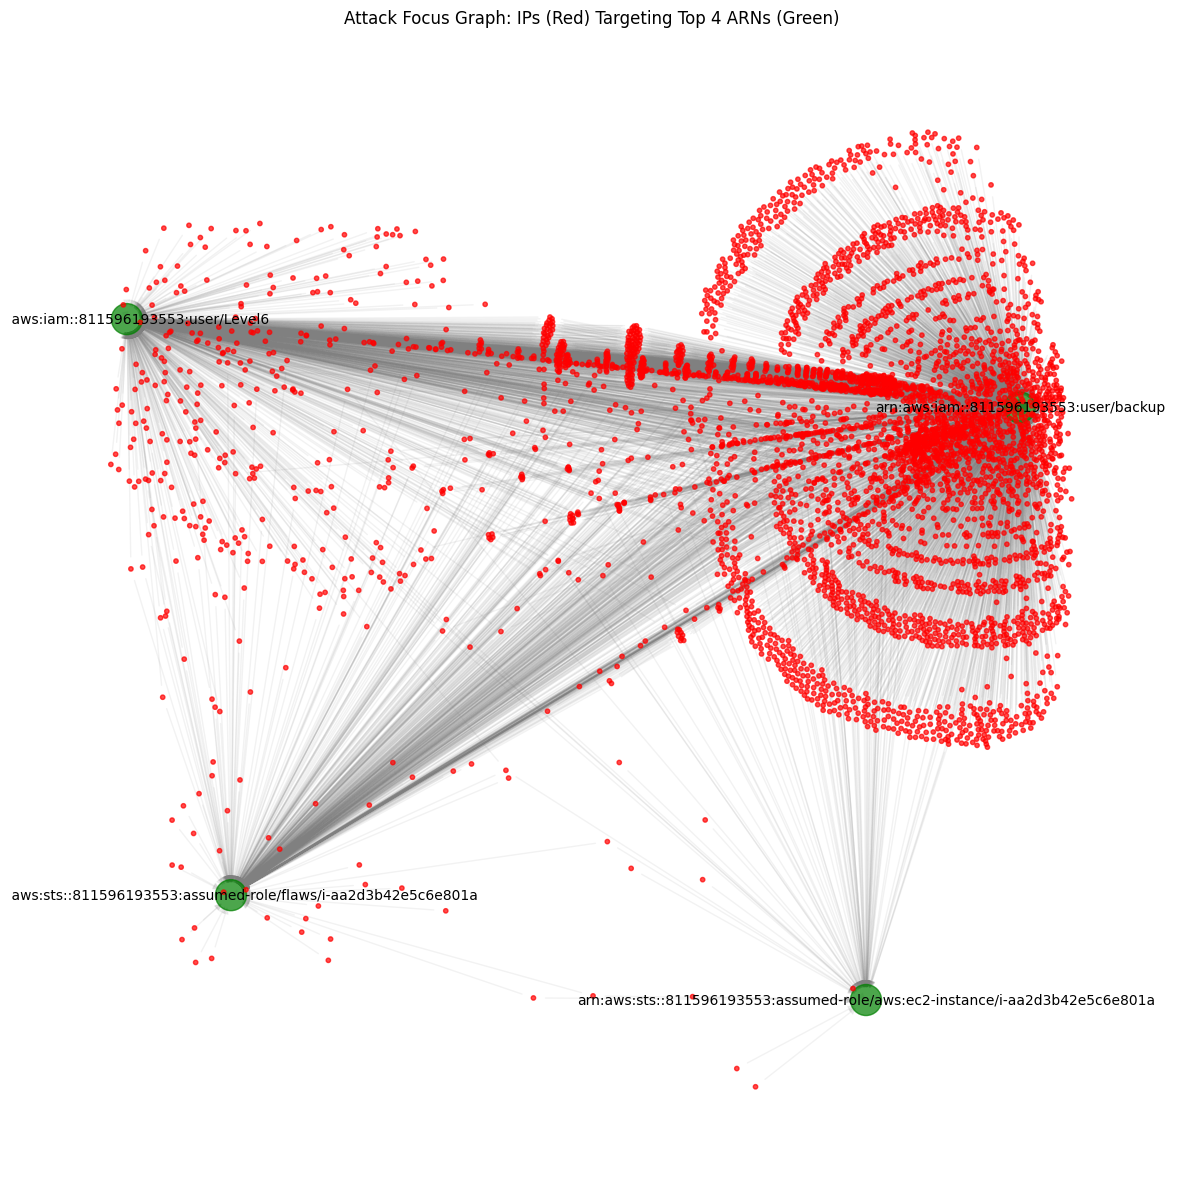

Saved 'attack_focus_graph.png'.


In [15]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# --- 1. Load the "Ground Truth" Attack Data ---
csv_file = 'ground_truth_attack_events.csv'
print(f"\nLoading 'Malicious' events from {csv_file} to build resource graph...")

# We only need the principal (actor) and the target (resource)
columns_to_load = ['sourceIPAddress', 'userIdentity.arn']
df_attack = pd.read_csv(csv_file, usecols=columns_to_load)

# --- 2. Build the Resource-Focus Graph ---
G_focus = nx.DiGraph()
print("Building the resource-focus graph...")

# --- THIS IS THE FIX ---
# We use .to_dict('records') to loop through the rows as dictionaries.
# This correctly handles column names with a '.'
for row in df_attack.to_dict('records'):
    ip = row.get('sourceIPAddress')
    target_arn = row.get('userIdentity.arn')
    
    # Check for missing values (None or NaN)
    if not ip or pd.isna(ip) or not target_arn or pd.isna(target_arn):
        continue
        
    # Add nodes
    if not G_focus.has_node(ip):
        G_focus.add_node(ip, type='IP')
    if not G_focus.has_node(target_arn):
        G_focus.add_node(target_arn, type='ARN')
        
    # Add edge (if it doesn't exist) to represent the "targeting" relationship
    if not G_focus.has_edge(ip, target_arn):
        G_focus.add_edge(ip, target_arn, weight=1)
    else:
        # If edge already exists, increase its weight (shows repeated attacks)
        G_focus.edges[ip, target_arn]['weight'] += 1

print(f"Focus Graph built with {G_focus.number_of_nodes()} nodes and {G_focus.number_of_edges()} edges.")

# --- 3. Visualize the "Many-to-Few" Pattern ---
print("\nCreating subgraph for visualization...")

# Find the top 4 targets (from your previous analysis)
top_targets = [
    'arn:aws:iam::811596193553:user/backup',
    'arn:aws:iam::811596193553:user/Level6',
    'arn:aws:sts::811596193553:assumed-role/flaws/i-aa2d3b42e5c6e801a',
    'arn:aws:sts::811596193553:assumed-role/aws:ec2-instance/i-aa2d3b42e5c6e801a'
]

# Get all IPs that targeted any of these top 4
nodes_to_plot = set(top_targets)
for ip, target in G_focus.edges():
    if target in top_targets:
        nodes_to_plot.add(ip)

# Create a subgraph of just these nodes
G_sub_focus = G_focus.subgraph(nodes_to_plot)

print(f"Subgraph created with {G_sub_focus.number_of_nodes()} nodes and {G_sub_focus.number_of_edges()} edges.")

# --- 4. Visualize the Subgraph ---
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G_sub_focus, k=0.1, seed=42)

# Color nodes by type
colors = ['red' if G_sub_focus.nodes[n]['type'] == 'IP' else 'green' for n in G_sub_focus.nodes()]
sizes = [10 if G_sub_focus.nodes[n]['type'] == 'IP' else 500 for n in G_sub_focus.nodes()]

nx.draw_networkx_nodes(G_sub_focus, pos, node_color=colors, node_size=sizes, alpha=0.7)
nx.draw_networkx_edges(G_sub_focus, pos, edge_color='gray', alpha=0.1)

# Label only the target ARNs
labels = {n:n for n in G_sub_focus.nodes() if G_sub_focus.nodes[n]['type'] == 'ARN'}
nx.draw_networkx_labels(G_sub_focus, pos, labels=labels, font_size=10, font_color='black')

plt.title("Attack Focus Graph: IPs (Red) Targeting Top 4 ARNs (Green)")
plt.axis('off')
plt.savefig('attack_focus_graph.png')
plt.show()

print("Saved 'attack_focus_graph.png'.")

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import time

# --- Import the Models ---
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
try:
    from xgboost import XGBClassifier
    xgboost_available = True
except ImportError:
    print("XGBoost not found. Run 'pip install xgboost' to include it in the comparison.")
    xgboost_available = False

# --- 1. Load Your New, Balanced Dataset (with 'eventTime') ---
csv_file = 'final_ml_training_dataset.csv'
print(f"Loading balanced ML dataset from '{csv_file}'...")

# We need eventTime to create non-leaky features
columns_to_load = ['eventTime', 'sourceIPAddress', 'userIdentity.arn', 'label']

try:
    df_ml = pd.read_csv(csv_file, usecols=columns_to_load)
    print(f"Successfully loaded {len(df_ml)} events.")
except Exception as e:
    print(f"Error loading CSV: {e}")
    print("Please ensure the file 'final_ml_training_dataset.csv' is in the same directory as your notebook.")
    # Create an empty DataFrame to prevent the rest of the script from erroring
    df_ml = pd.DataFrame(columns=columns_to_load)

# Proceed only if data was loaded
if not df_ml.empty:

    # --- 2. Create Non-Leaky Features ---
    print("Creating time-based (non-leaky) features...")
    # Convert eventTime to datetime objects
    df_ml['eventTime'] = pd.to_datetime(df_ml['eventTime'], errors='coerce')
    # Create time-based features
    df_ml['hour_of_day'] = df_ml['eventTime'].dt.hour
    df_ml['day_of_week'] = df_ml['eventTime'].dt.dayofweek

    # --- 3. Define Features (X) and Target (y) (NON-LEAKY) ---
    print("Preparing features and target (excluding 'event_name')...")

    # 'event_name' is REMOVED from features to prevent data leakage
    categorical_features = ['sourceIPAddress', 'userIdentity.arn']
    numerical_features = ['hour_of_day', 'day_of_week']

    # Handle missing values that might have been created
    df_ml[categorical_features] = df_ml[categorical_features].fillna('missing')
    df_ml[numerical_features] = df_ml[numerical_features].fillna(0) # Fill time NaNs with 0

    X = df_ml[categorical_features + numerical_features]
    y = df_ml['label'] # The 'label' column (0 or 1)

    # --- 4. Create Preprocessor (Memory-Safe) ---
    preprocessor = ColumnTransformer(
        transformers=[
            # Use default sparse=True for OneHotEncoder to prevent MemoryError
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('num', StandardScaler(), numerical_features) # Scale our new time features
        ])

    # --- 5. Split the Data ---
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    print(f"Data split into {len(X_train)} training and {len(X_test)} testing samples.")

    # --- 6. Define Models to Compare ---
    models_to_compare = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1)
    }
    if xgboost_available:
        models_to_compare['XGBoost'] = XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss')

    # --- 7. Train and Evaluate Each Model ---
    print("\nTraining and evaluating models on non-leaky features... (This may take some time)")
    performance_results = {}

    for name, model in models_to_compare.items():
        print(f"--- Testing: {name} ---")
        start_time = time.time()
        
        pipeline = Pipeline(steps=[
            ('preprocess', preprocessor),
            ('classifier', model)
        ])
        
        # Train the model
        pipeline.fit(X_train, y_train)
        
        # Make predictions on the test set
        y_pred = pipeline.predict(X_test)
        
        # Get the classification report
        report = classification_report(y_test, y_pred, target_names=['Benign', 'Malicious'], output_dict=True, zero_division=0)
        
        end_time = time.time()
        
        performance_results[name] = {
            'Accuracy': report['accuracy'],
            'Precision (Malicious)': report['Malicious']['precision'],
            'Recall (Malicious)': report['Malicious']['recall'],
            'F1-Score (Malicious)': report['Malicious']['f1-score'],
            'Training Time (s)': round(end_time - start_time, 2)
        }

    # --- 8. Display Final (and REALISTIC) Comparison Table ---
    print("\n--- Model Performance Comparison (Non-Leaky Features) ---")
    results_df = pd.DataFrame.from_dict(performance_results, orient='index')
    results_df = results_df.sort_values(by='F1-Score (Malicious)', ascending=False)

    display(results_df) # Use display() for a nice table in Jupyter

Loading balanced ML dataset from 'final_ml_training_dataset.csv'...
Successfully loaded 487606 events.
Creating time-based (non-leaky) features...
Preparing features and target (excluding 'event_name')...
Data split into 341324 training and 146282 testing samples.

Training and evaluating models on non-leaky features... (This may take some time)
--- Testing: Logistic Regression ---
--- Testing: Decision Tree ---
--- Testing: Random Forest ---
--- Testing: XGBoost ---


C:\Users\suman\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [00:11:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Model Performance Comparison (Non-Leaky Features) ---


Accuracy  Precision (Malicious)  Recall (Malicious)  \
Random Forest        0.970420               0.980612            0.959817   
Decision Tree        0.969853               0.981492            0.957767   
XGBoost              0.966777               0.980575            0.952421   
Logistic Regression  0.964883               0.968308            0.961226   

                     F1-Score (Malicious)  Training Time (s)  
Random Forest                    0.970103             163.89  
Decision Tree                    0.969484              48.55  
XGBoost                          0.966293               5.10  
Logistic Regression              0.964754              25.40

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# --- 1. Load the Balanced ML Dataset ---
csv_file = 'final_ml_training_dataset.csv'
print(f"Loading balanced ML dataset from '{csv_file}'...")

# We only need these columns for this analysis
columns_to_load = ['eventTime', 'event_name', 'sourceIPAddress', 'label']

df_ml = pd.read_csv(csv_file, usecols=columns_to_load, parse_dates=['eventTime'])
df_ml.fillna('missing', inplace=True) # Clean up any missing values
print(f"Successfully loaded {len(df_ml)} events.")

# --- 2. Find Interesting Actors to Analyze ---

# Find a "Malicious" IP (label=1) that has many events
malicious_ips = df_ml[df_ml['label'] == 1]['sourceIPAddress'].value_counts()
target_malicious_ip = malicious_ips.index[0] # Get the most active malicious IP
print(f"\nIdentified Top Malicious Actor: {target_malicious_ip} (with {malicious_ips.iloc[0]} events)")

# Find a "Benign" IP (label=0) that has many events
benign_ips = df_ml[df_ml['label'] == 0]['sourceIPAddress'].value_counts()
target_benign_ip = benign_ips.index[0] # Get the most active benign IP
print(f"Identified Top Benign Actor: {target_benign_ip} (with {benign_ips.iloc[0]} events)")


Loading balanced ML dataset from 'final_ml_training_dataset.csv'...
Successfully loaded 487606 events.

Identified Top Malicious Actor: ec2.amazonaws.com (with 43555 events)
Identified Top Benign Actor: 5.205.62.253 (with 179991 events)


In [2]:
def create_actor_timeline_graph(df_actor, title):
    """
    Creates and visualizes a chronological event graph for a single actor's DataFrame.
    Nodes are events, and edges connect them in order of time.
    """
    if df_actor.empty:
        print(f"No data for {title}, skipping graph.")
        return None

    # Sort the actor's events by time, from oldest to newest
    df_actor = df_actor.sort_values('eventTime')
    
    # Initialize a new Directed Graph
    G = nx.DiGraph()
    
    # Create a mapping for node labels
    node_labels = {}
    node_colors = {}
    
    # Loop through the sorted DataFrame
    for i in range(len(df_actor)):
        # Get the current row (event)
        current_event = df_actor.iloc[i]
        
        # Use the DataFrame index as the unique node ID
        node_id = current_event.name
        
        # Add the node
        G.add_node(node_id)
        
        # Store its attributes (the event_name for the label, and color)
        node_labels[node_id] = current_event['event_name']
        node_colors[node_id] = 'red' if current_event['label'] == 1 else 'cornflowerblue'
        
        # --- Create the Edge ---
        # If this is not the first event, connect it to the previous event
        if i > 0:
            previous_event_node_id = df_actor.iloc[i-1].name
            # Add a directed edge from the previous event to the current one
            G.add_edge(previous_event_node_id, node_id)
            
    # --- Visualize the Graph ---
    plt.figure(figsize=(12, max(5, len(df_actor) * 0.5))) # Make plot taller for more events
    
    # Use a layout that shows the chain clearly
    pos = nx.spring_layout(G, k=0.8, iterations=20, seed=42)
    
    # Get the list of colors in the correct order
    colors = [node_colors[node] for node in G.nodes()]

    # Draw the graph
    nx.draw(
        G,
        pos,
        node_color=colors,
        labels=node_labels,
        with_labels=True,
        node_size=2000,
        font_size=8,
        font_weight='bold',
        arrows=True,
        arrowsize=20
    )
    
    plt.title(f"Event Chain for: {title}")
    plt.savefig(f"{title}_event_chain.png")
    plt.show()
    
    return G

print("Graphing function `create_actor_timeline_graph` defined.")

Graphing function `create_actor_timeline_graph` defined.


Loading balanced ML dataset from 'final_ml_training_dataset.csv'...
Successfully loaded 487606 events.

--- Identifying Top Actors for Analysis ---
Top 3 Malicious Actors: ['ec2.amazonaws.com', '193.29.252.218', '253.0.255.253']
Top 3 Benign Actors: ['5.205.62.253', '255.253.125.115', '240.252.161.77']

Graphing function `create_actor_timeline_graph` defined.

--- Generating Malicious Event Chains ---

Analyzing Malicious Actor: ec2.amazonaws.com
  (Actor has 43555 events. Plotting only the last 50.)
  (Graphviz/pydot not found, using 'spring' layout for Malicious_Actor_ec2.amazonaws.com.)


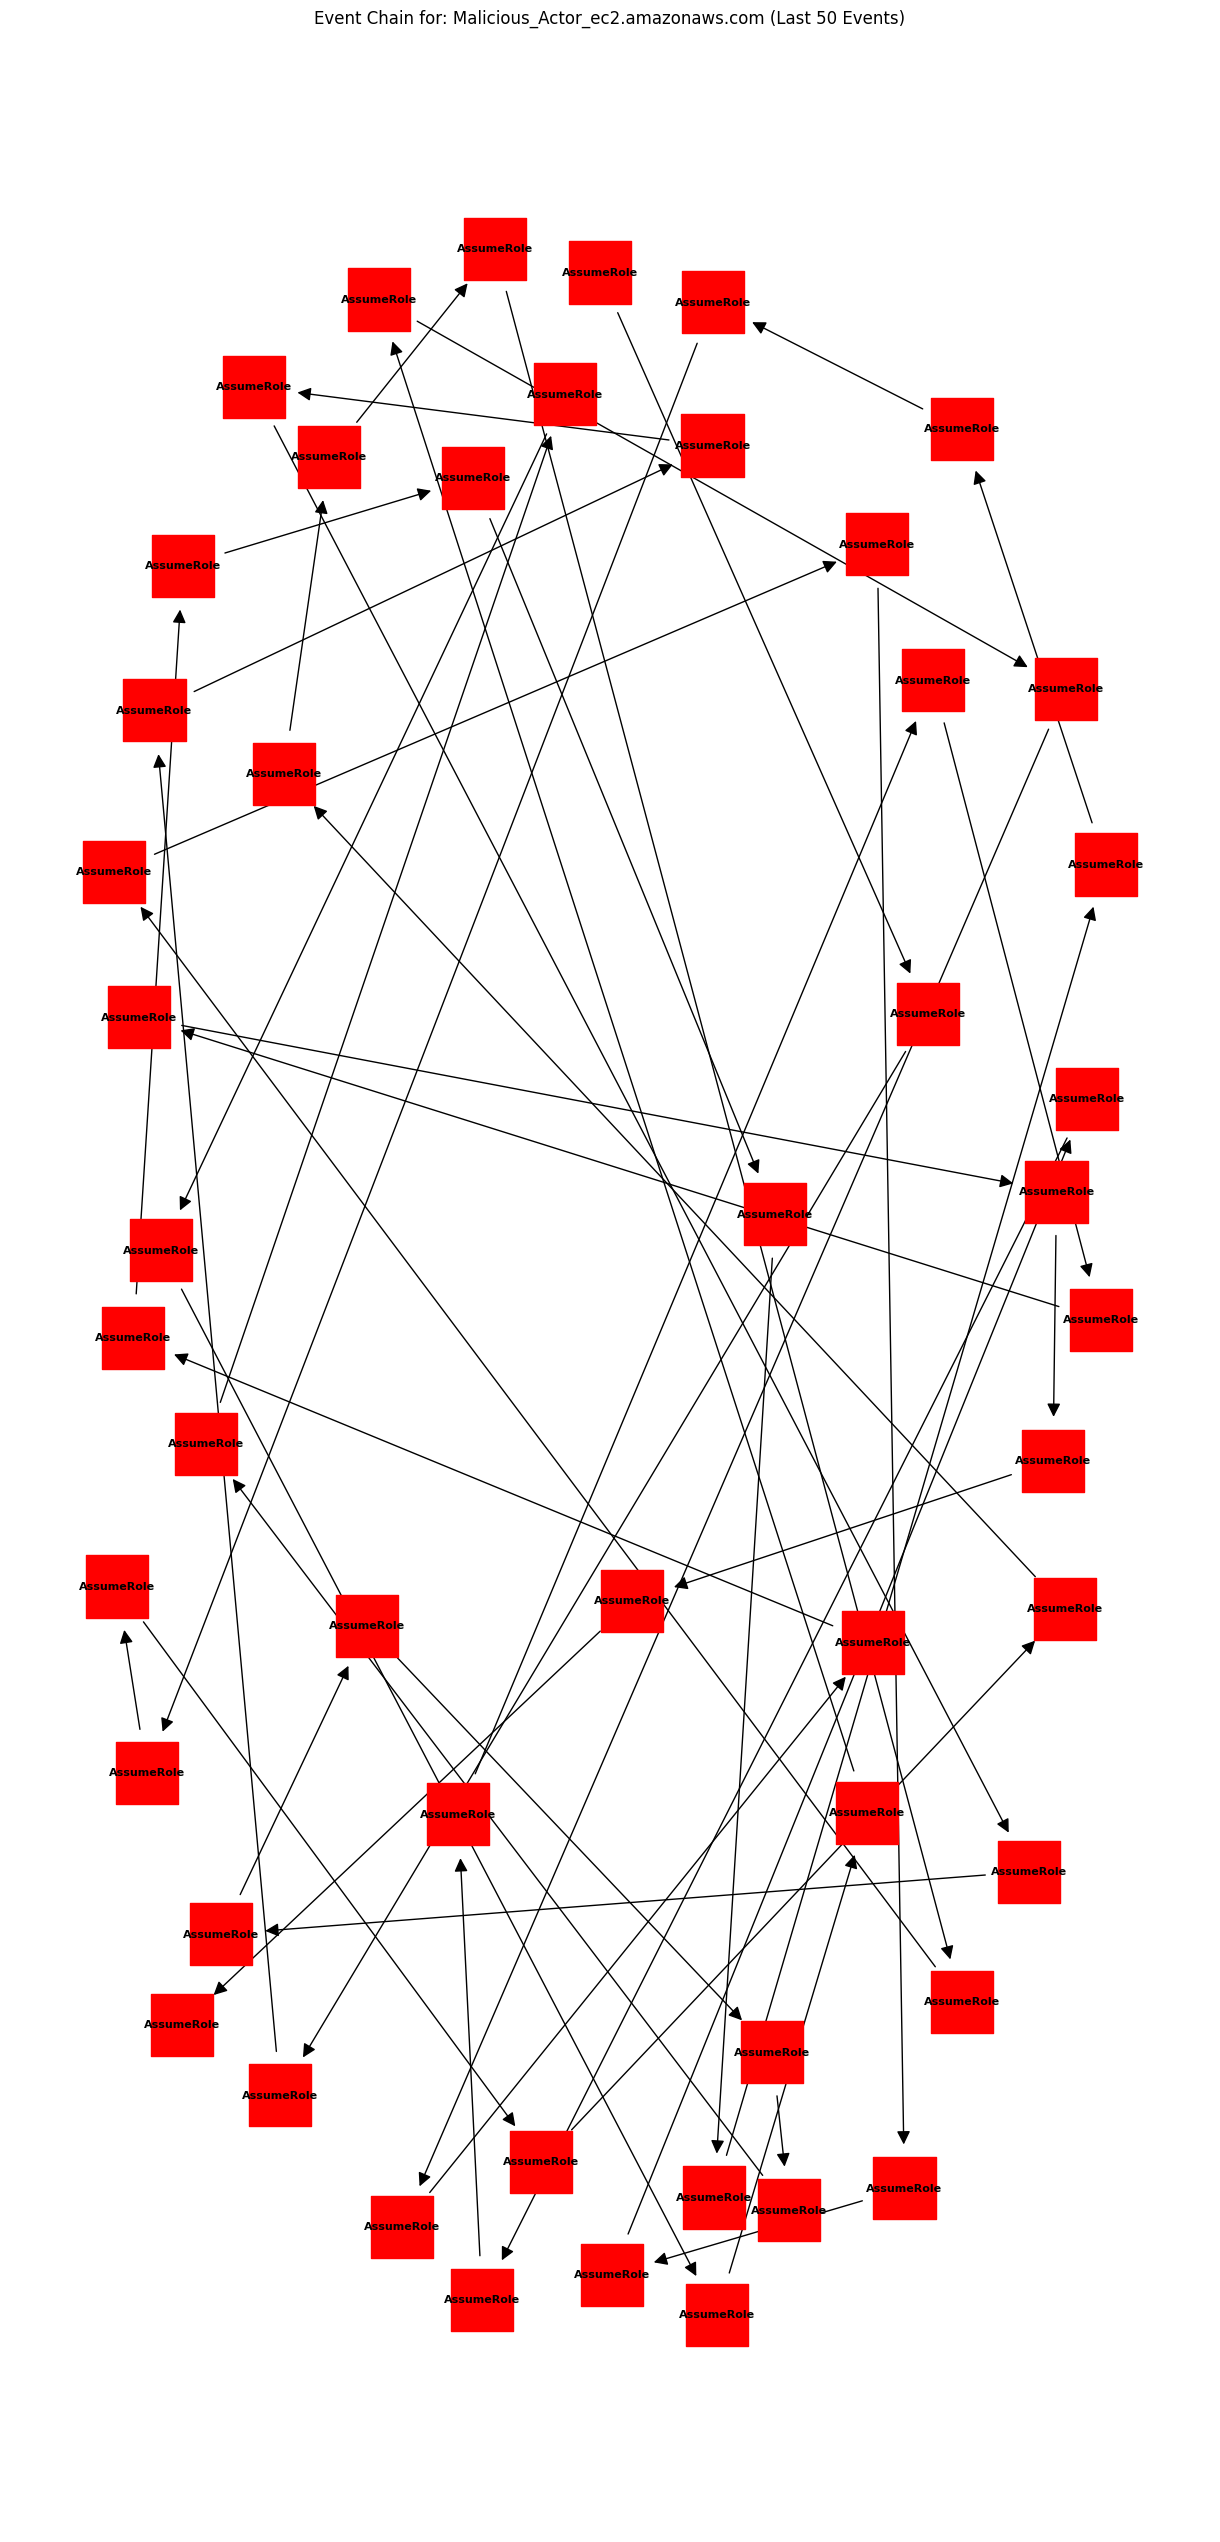


Analyzing Malicious Actor: 193.29.252.218
  (Actor has 23479 events. Plotting only the last 50.)
  (Graphviz/pydot not found, using 'spring' layout for Malicious_Actor_193.29.252.218.)


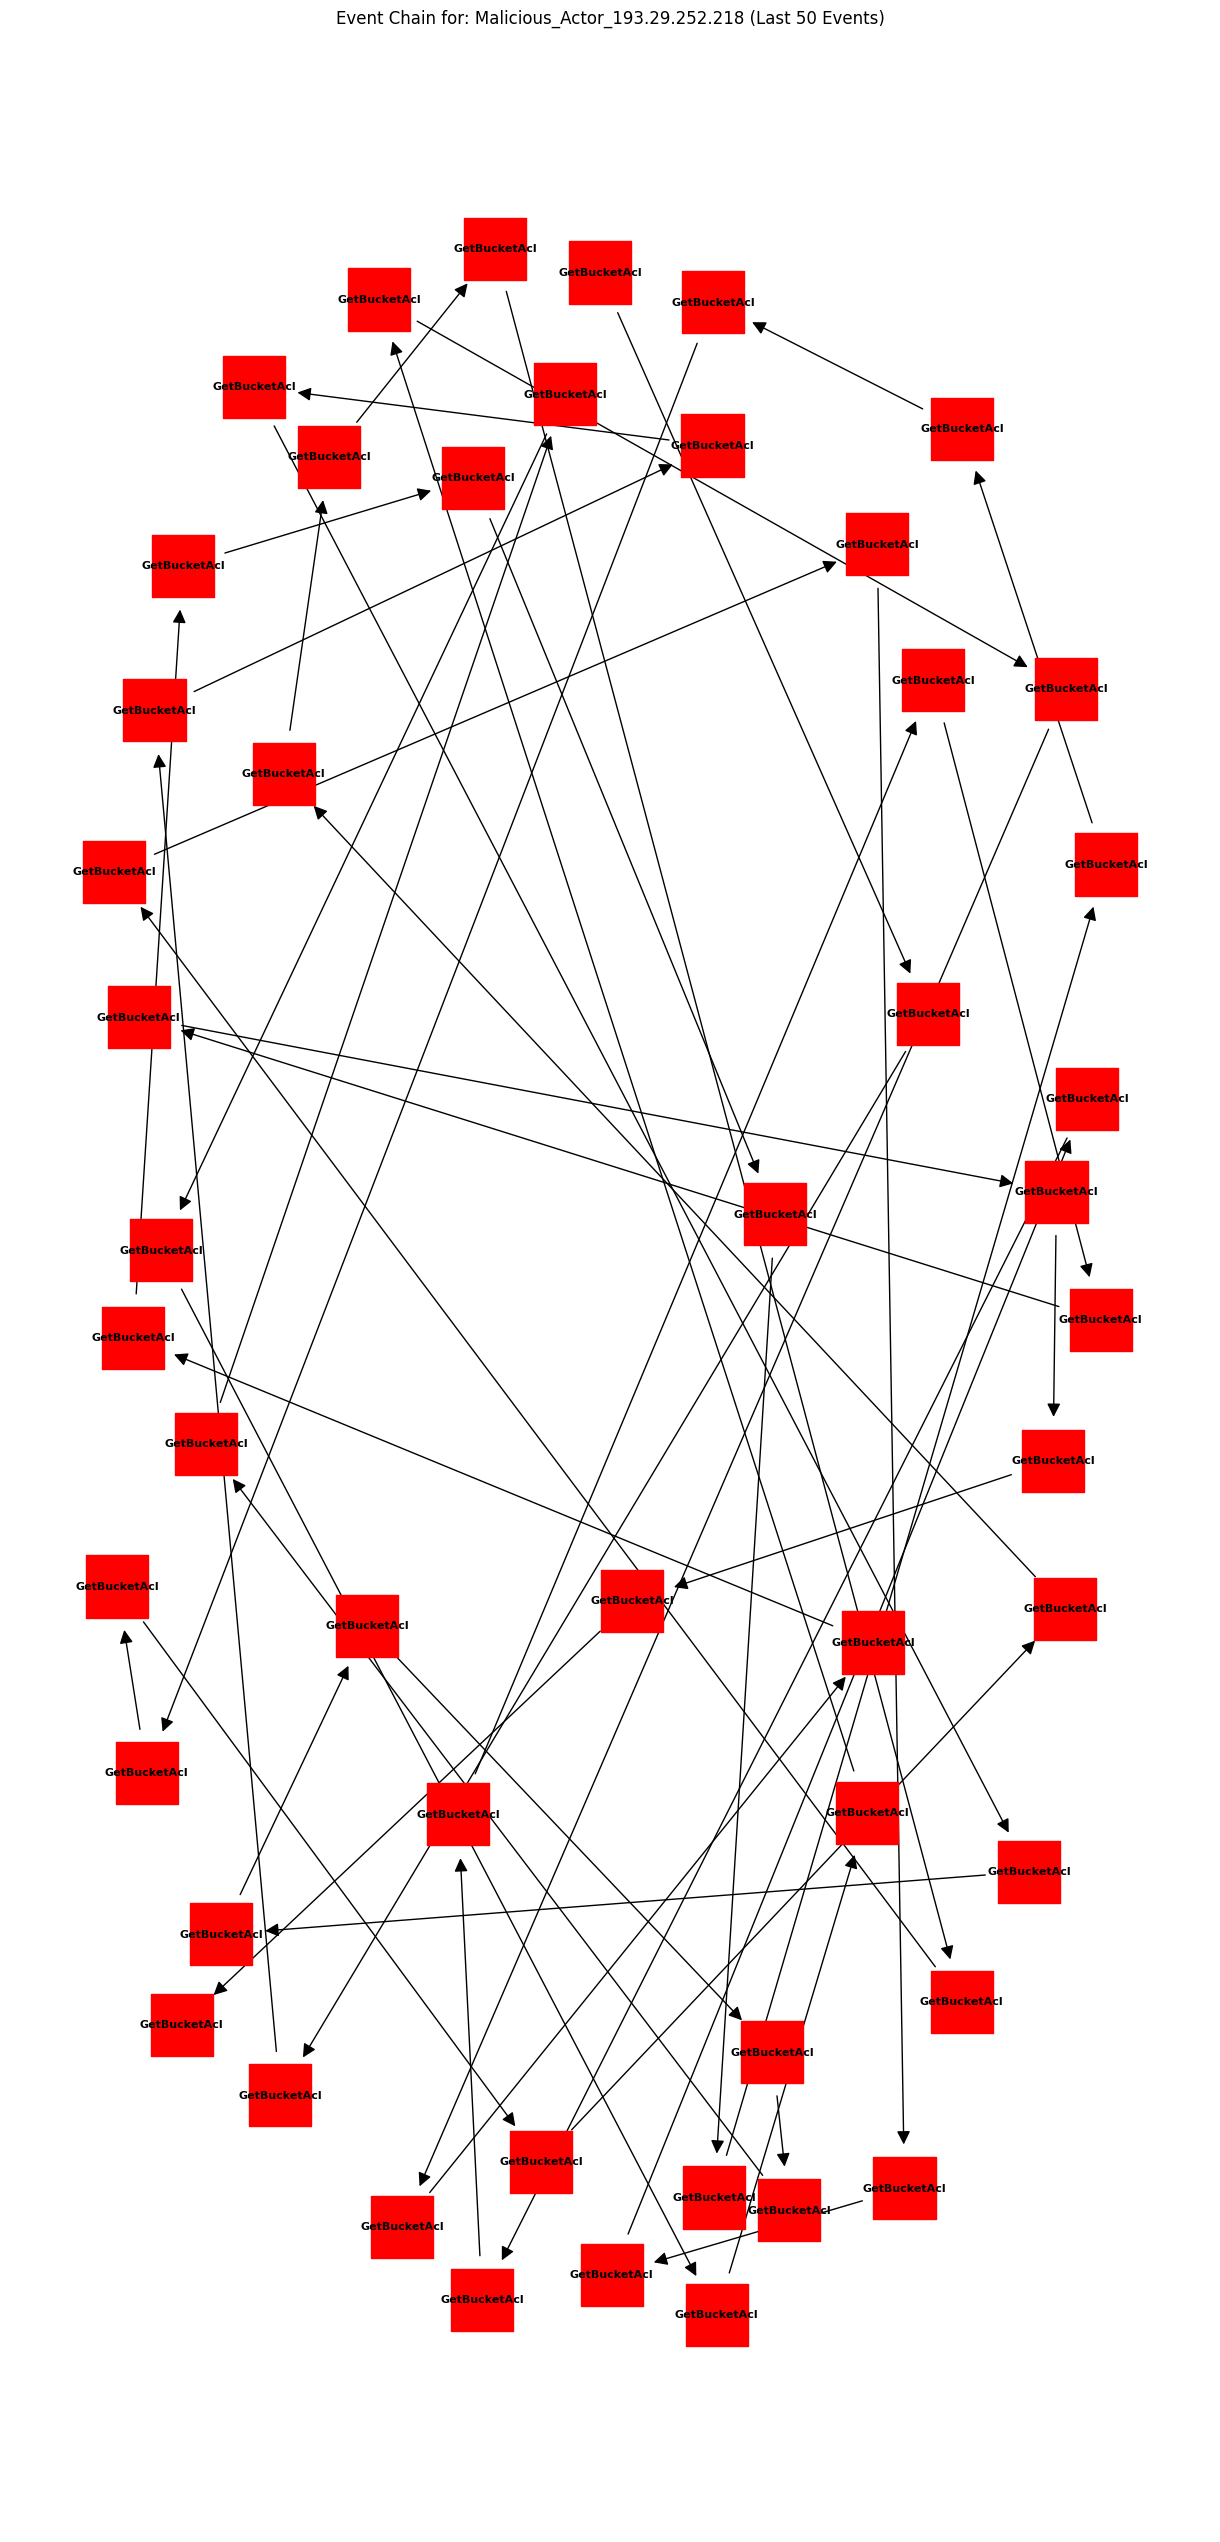


Analyzing Malicious Actor: 253.0.255.253
  (Actor has 9067 events. Plotting only the last 50.)
  (Graphviz/pydot not found, using 'spring' layout for Malicious_Actor_253.0.255.253.)


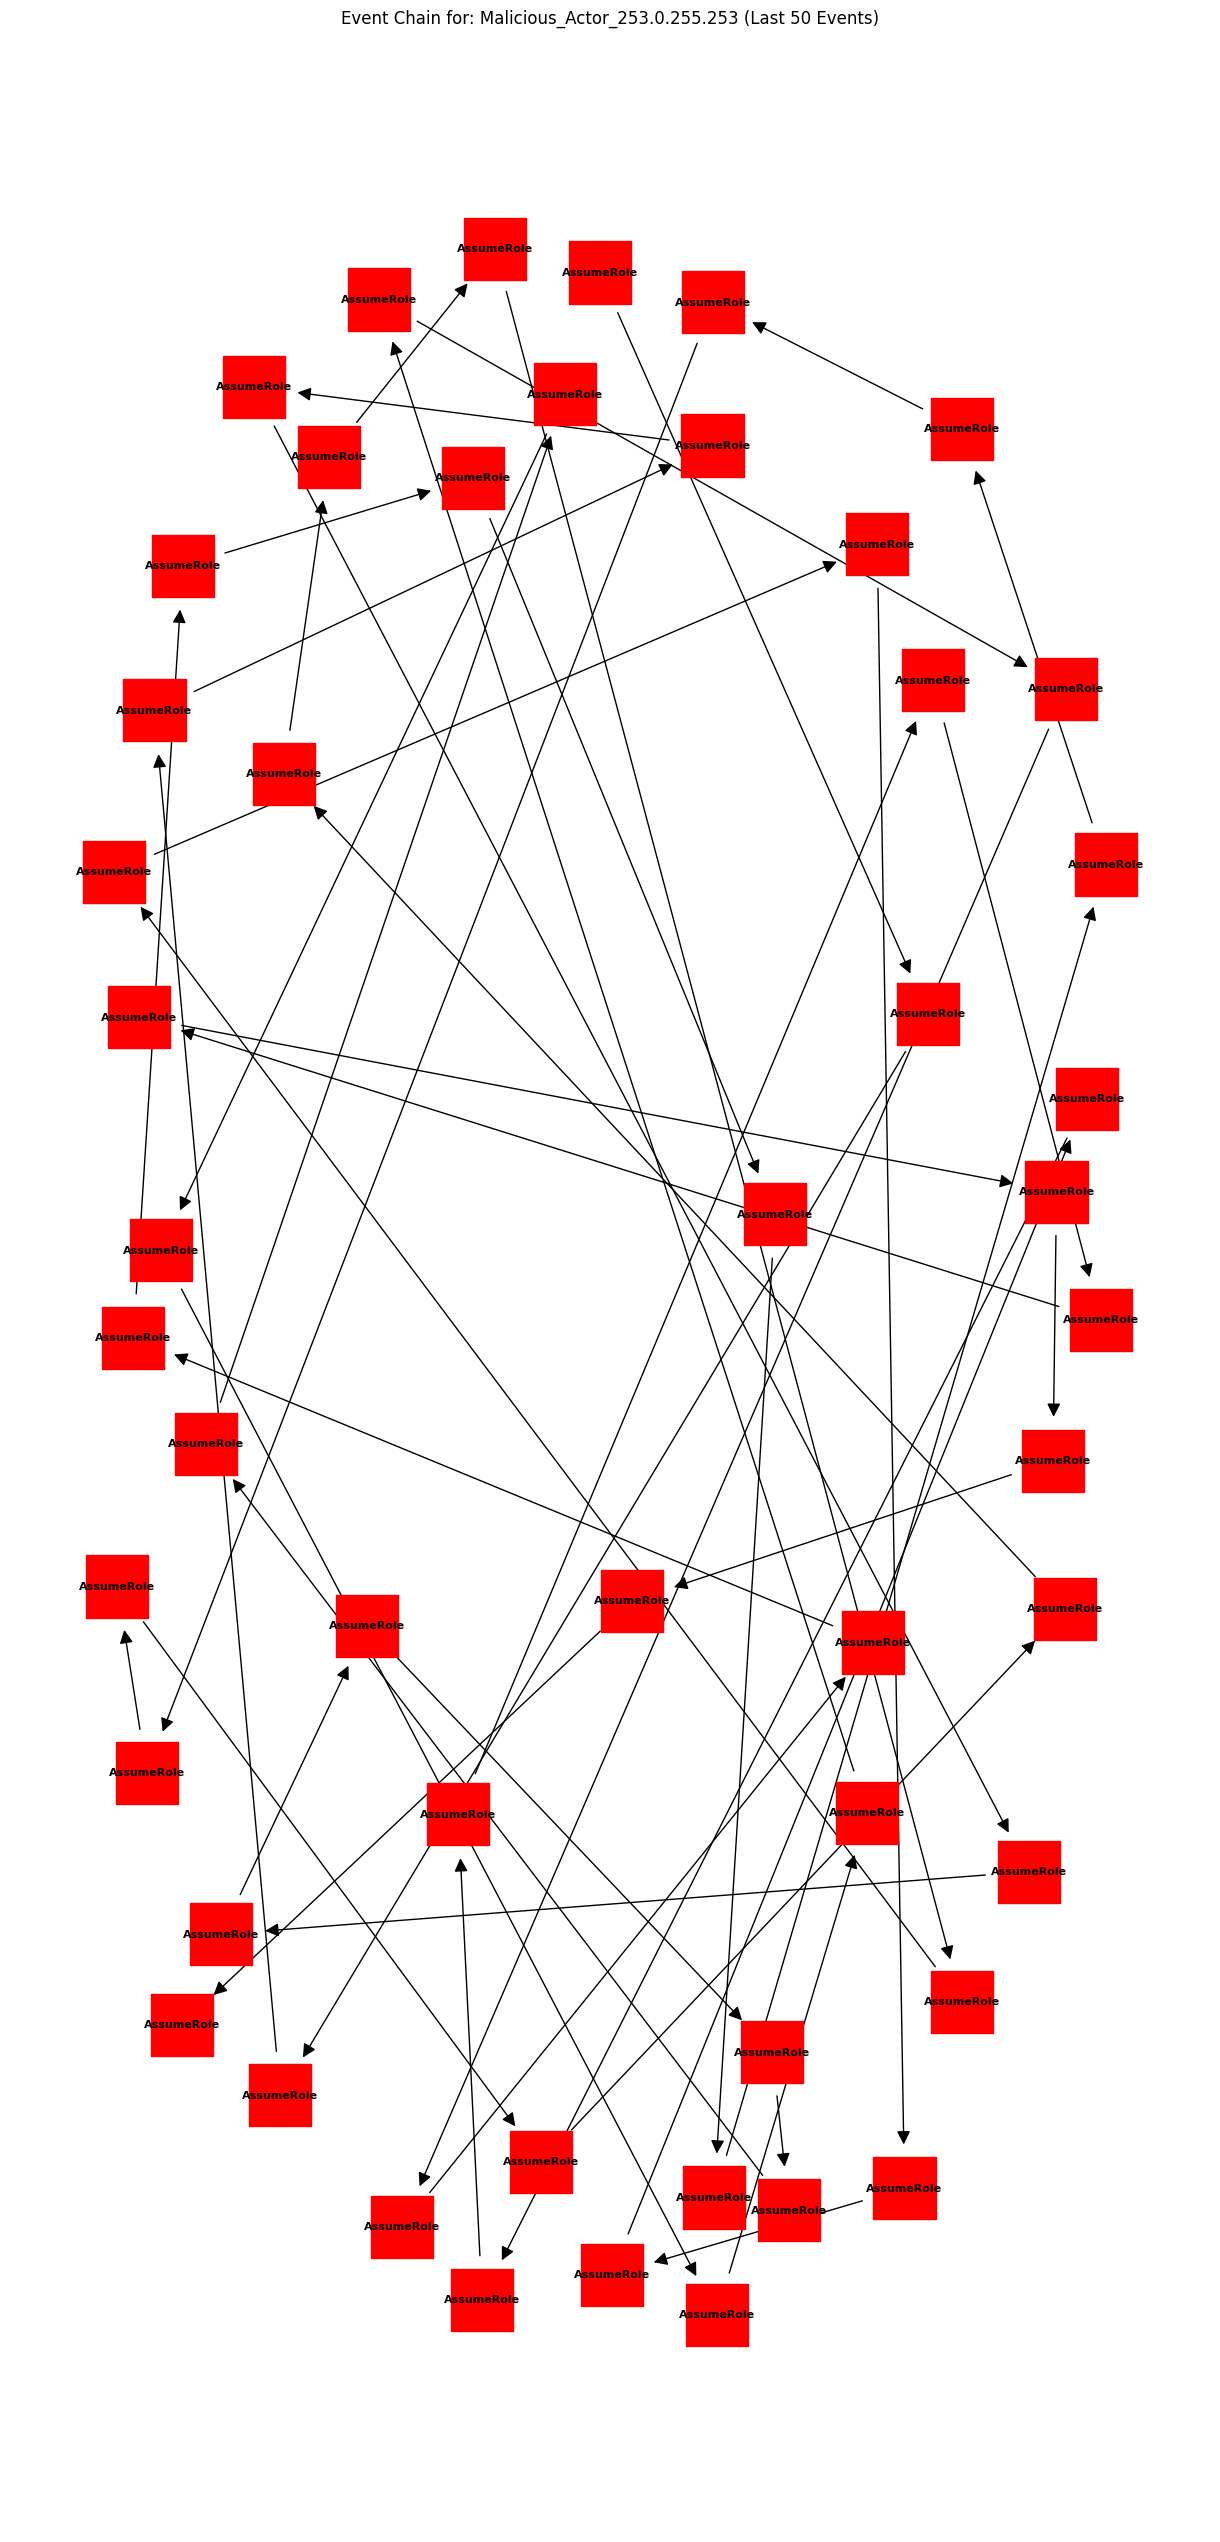


--- Generating Benign Event Chains ---

Analyzing Benign Actor: 5.205.62.253
  (Actor has 179995 events. Plotting only the last 50.)
  (Graphviz/pydot not found, using 'spring' layout for Benign_Actor_5.205.62.253.)


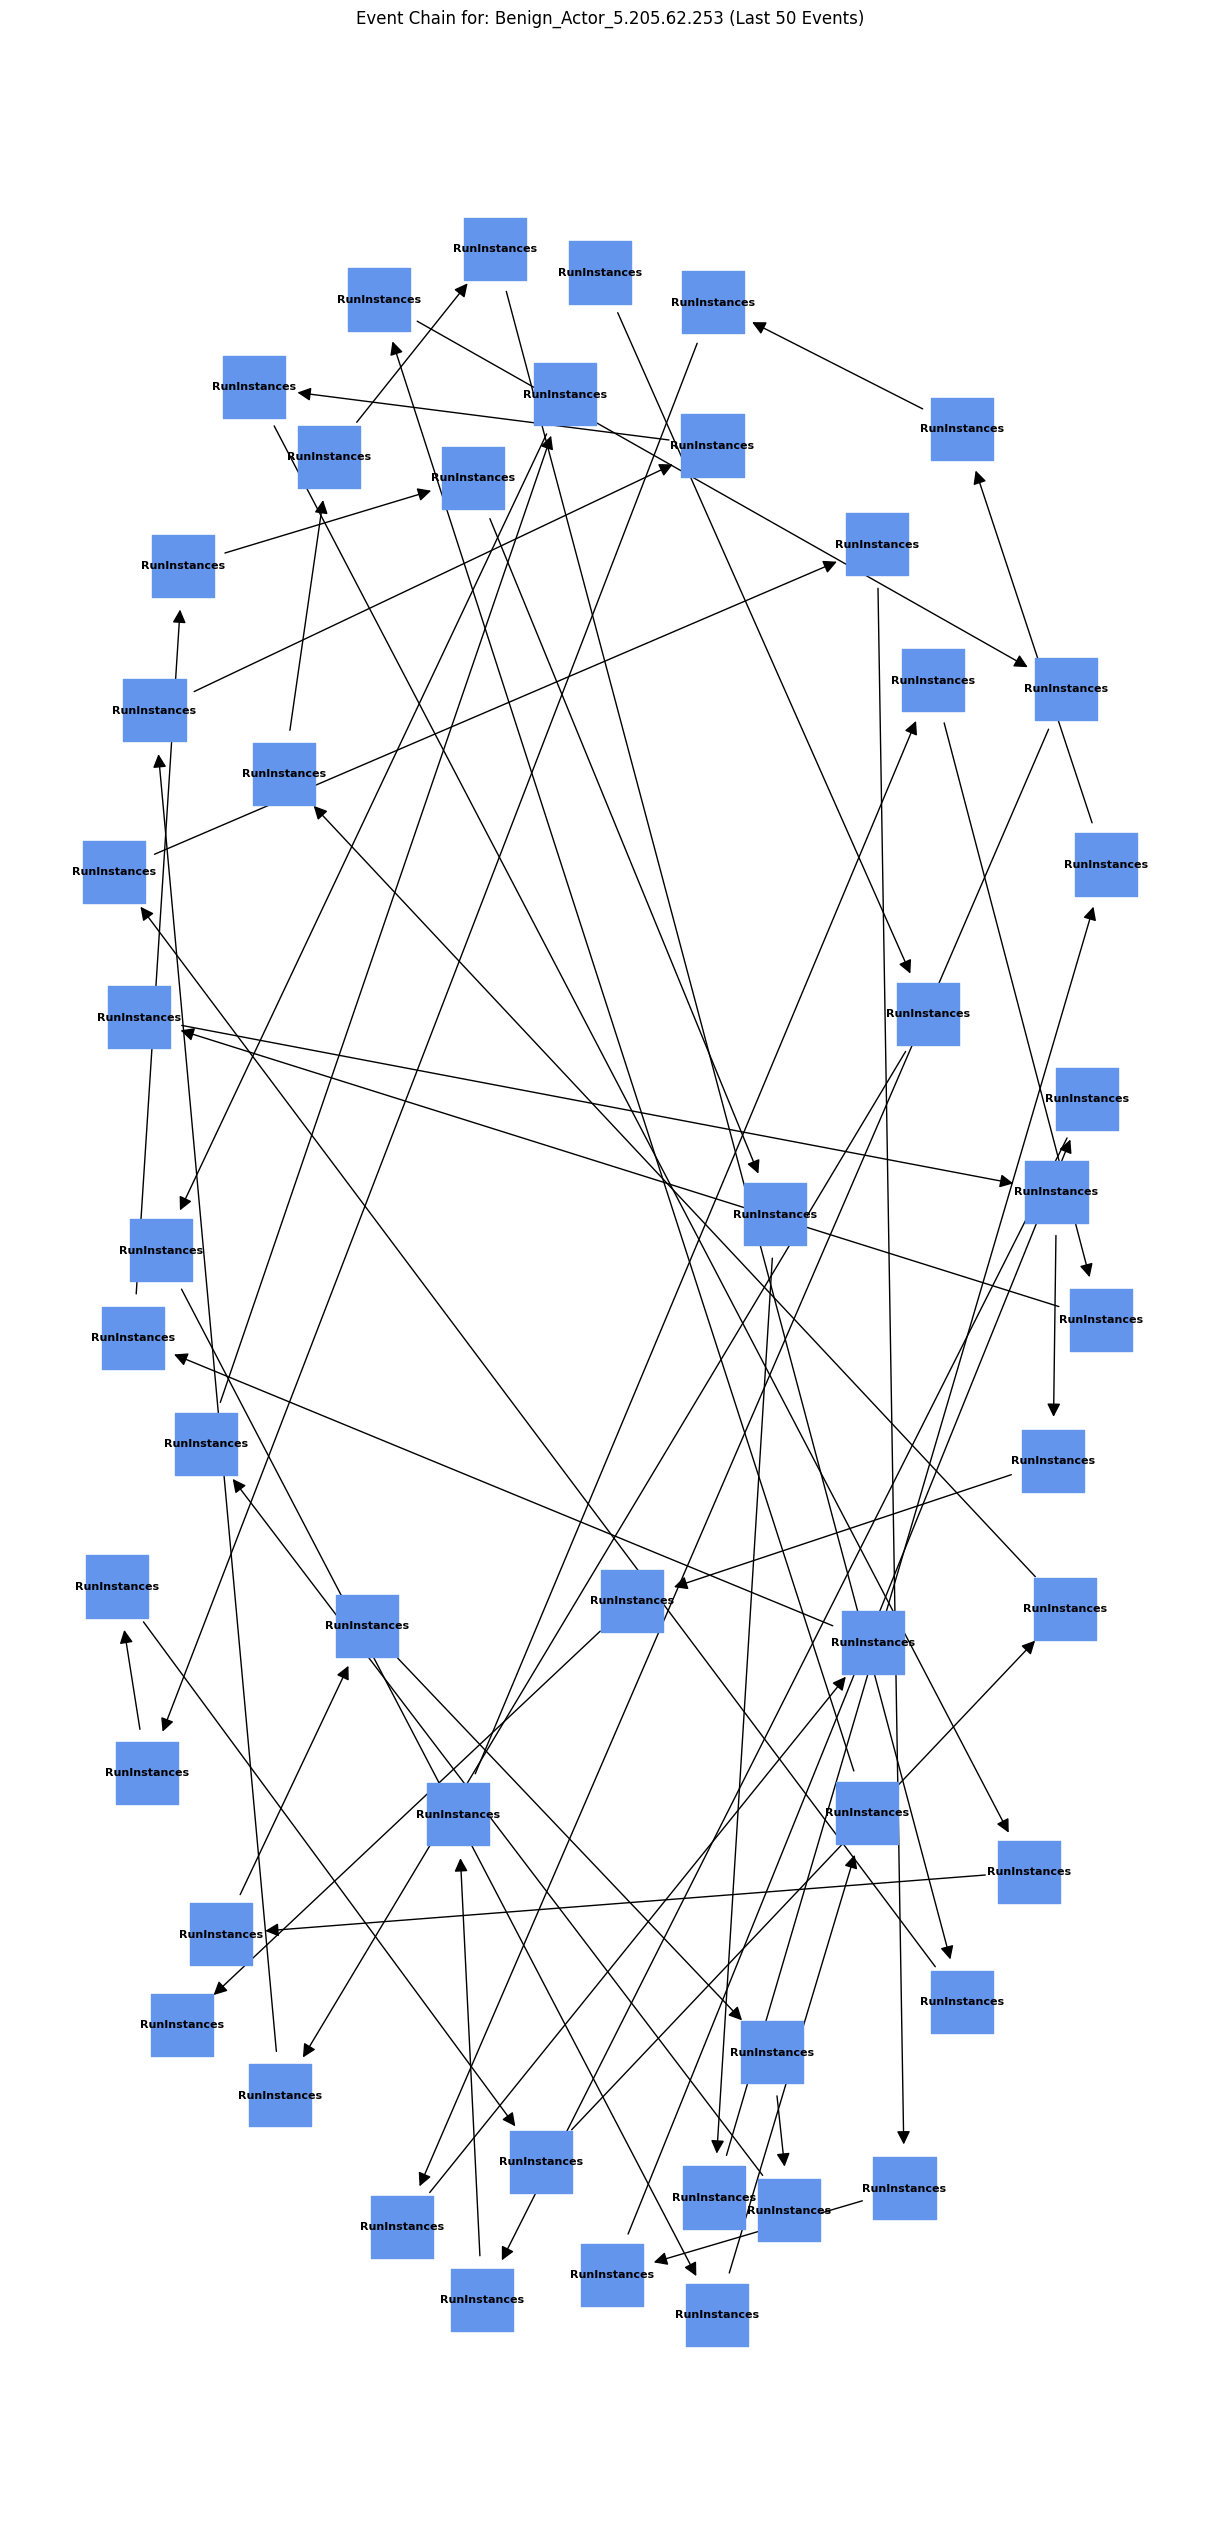


Analyzing Benign Actor: 255.253.125.115
  (Actor has 12272 events. Plotting only the last 50.)
  (Graphviz/pydot not found, using 'spring' layout for Benign_Actor_255.253.125.115.)


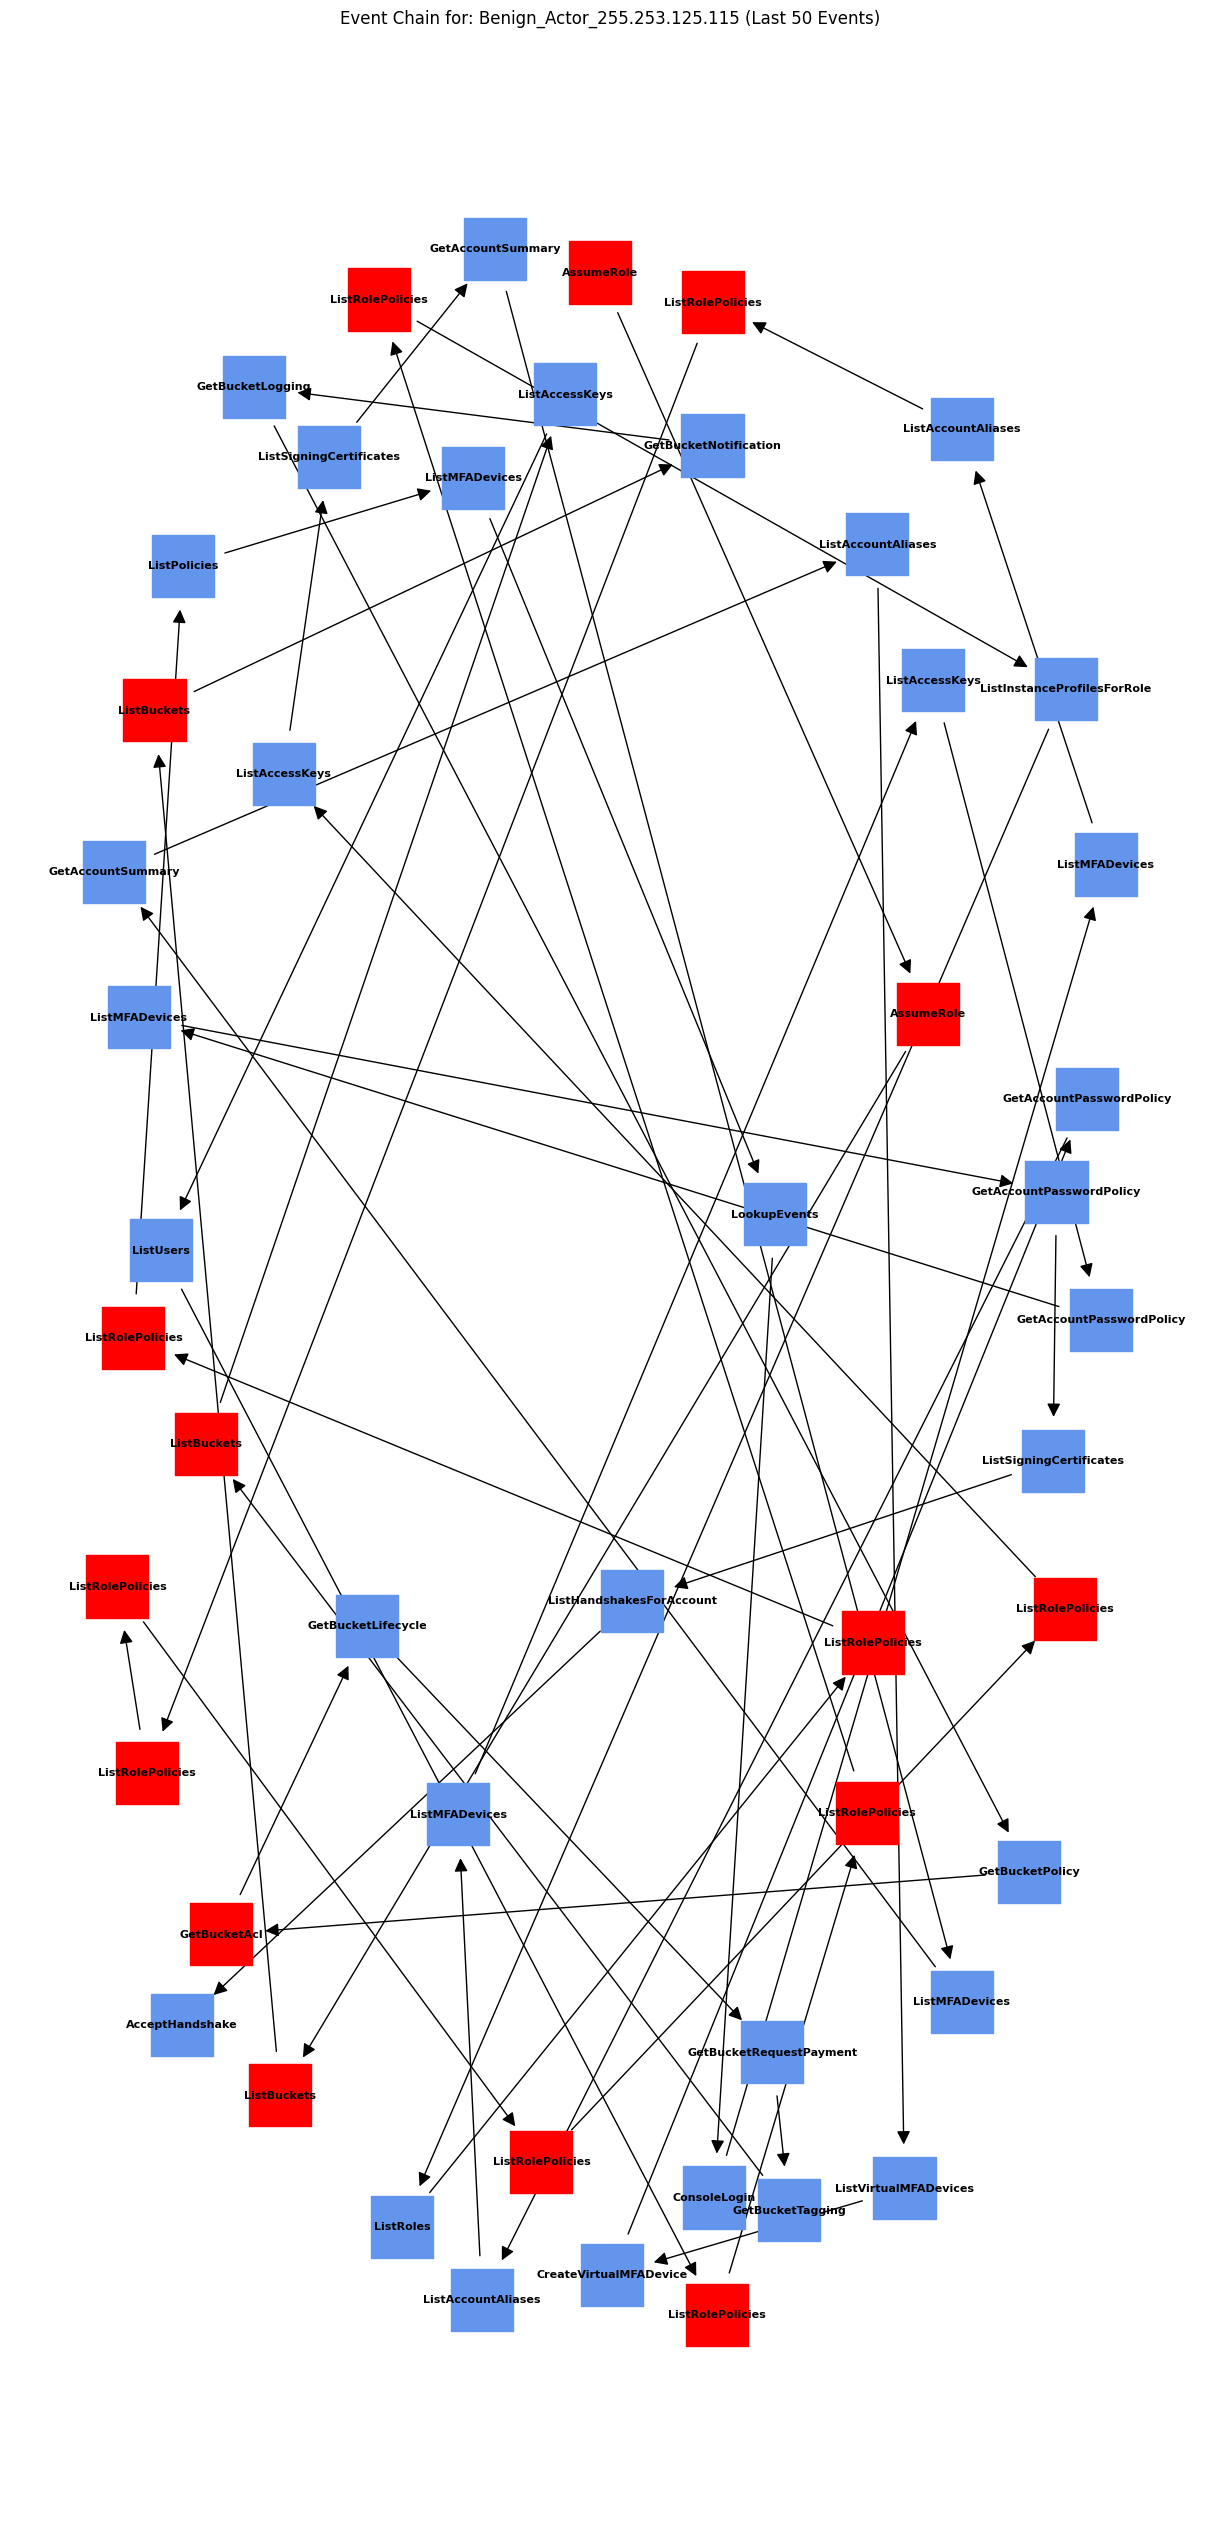


Analyzing Benign Actor: 240.252.161.77
  (Actor has 6690 events. Plotting only the last 50.)
  (Graphviz/pydot not found, using 'spring' layout for Benign_Actor_240.252.161.77.)


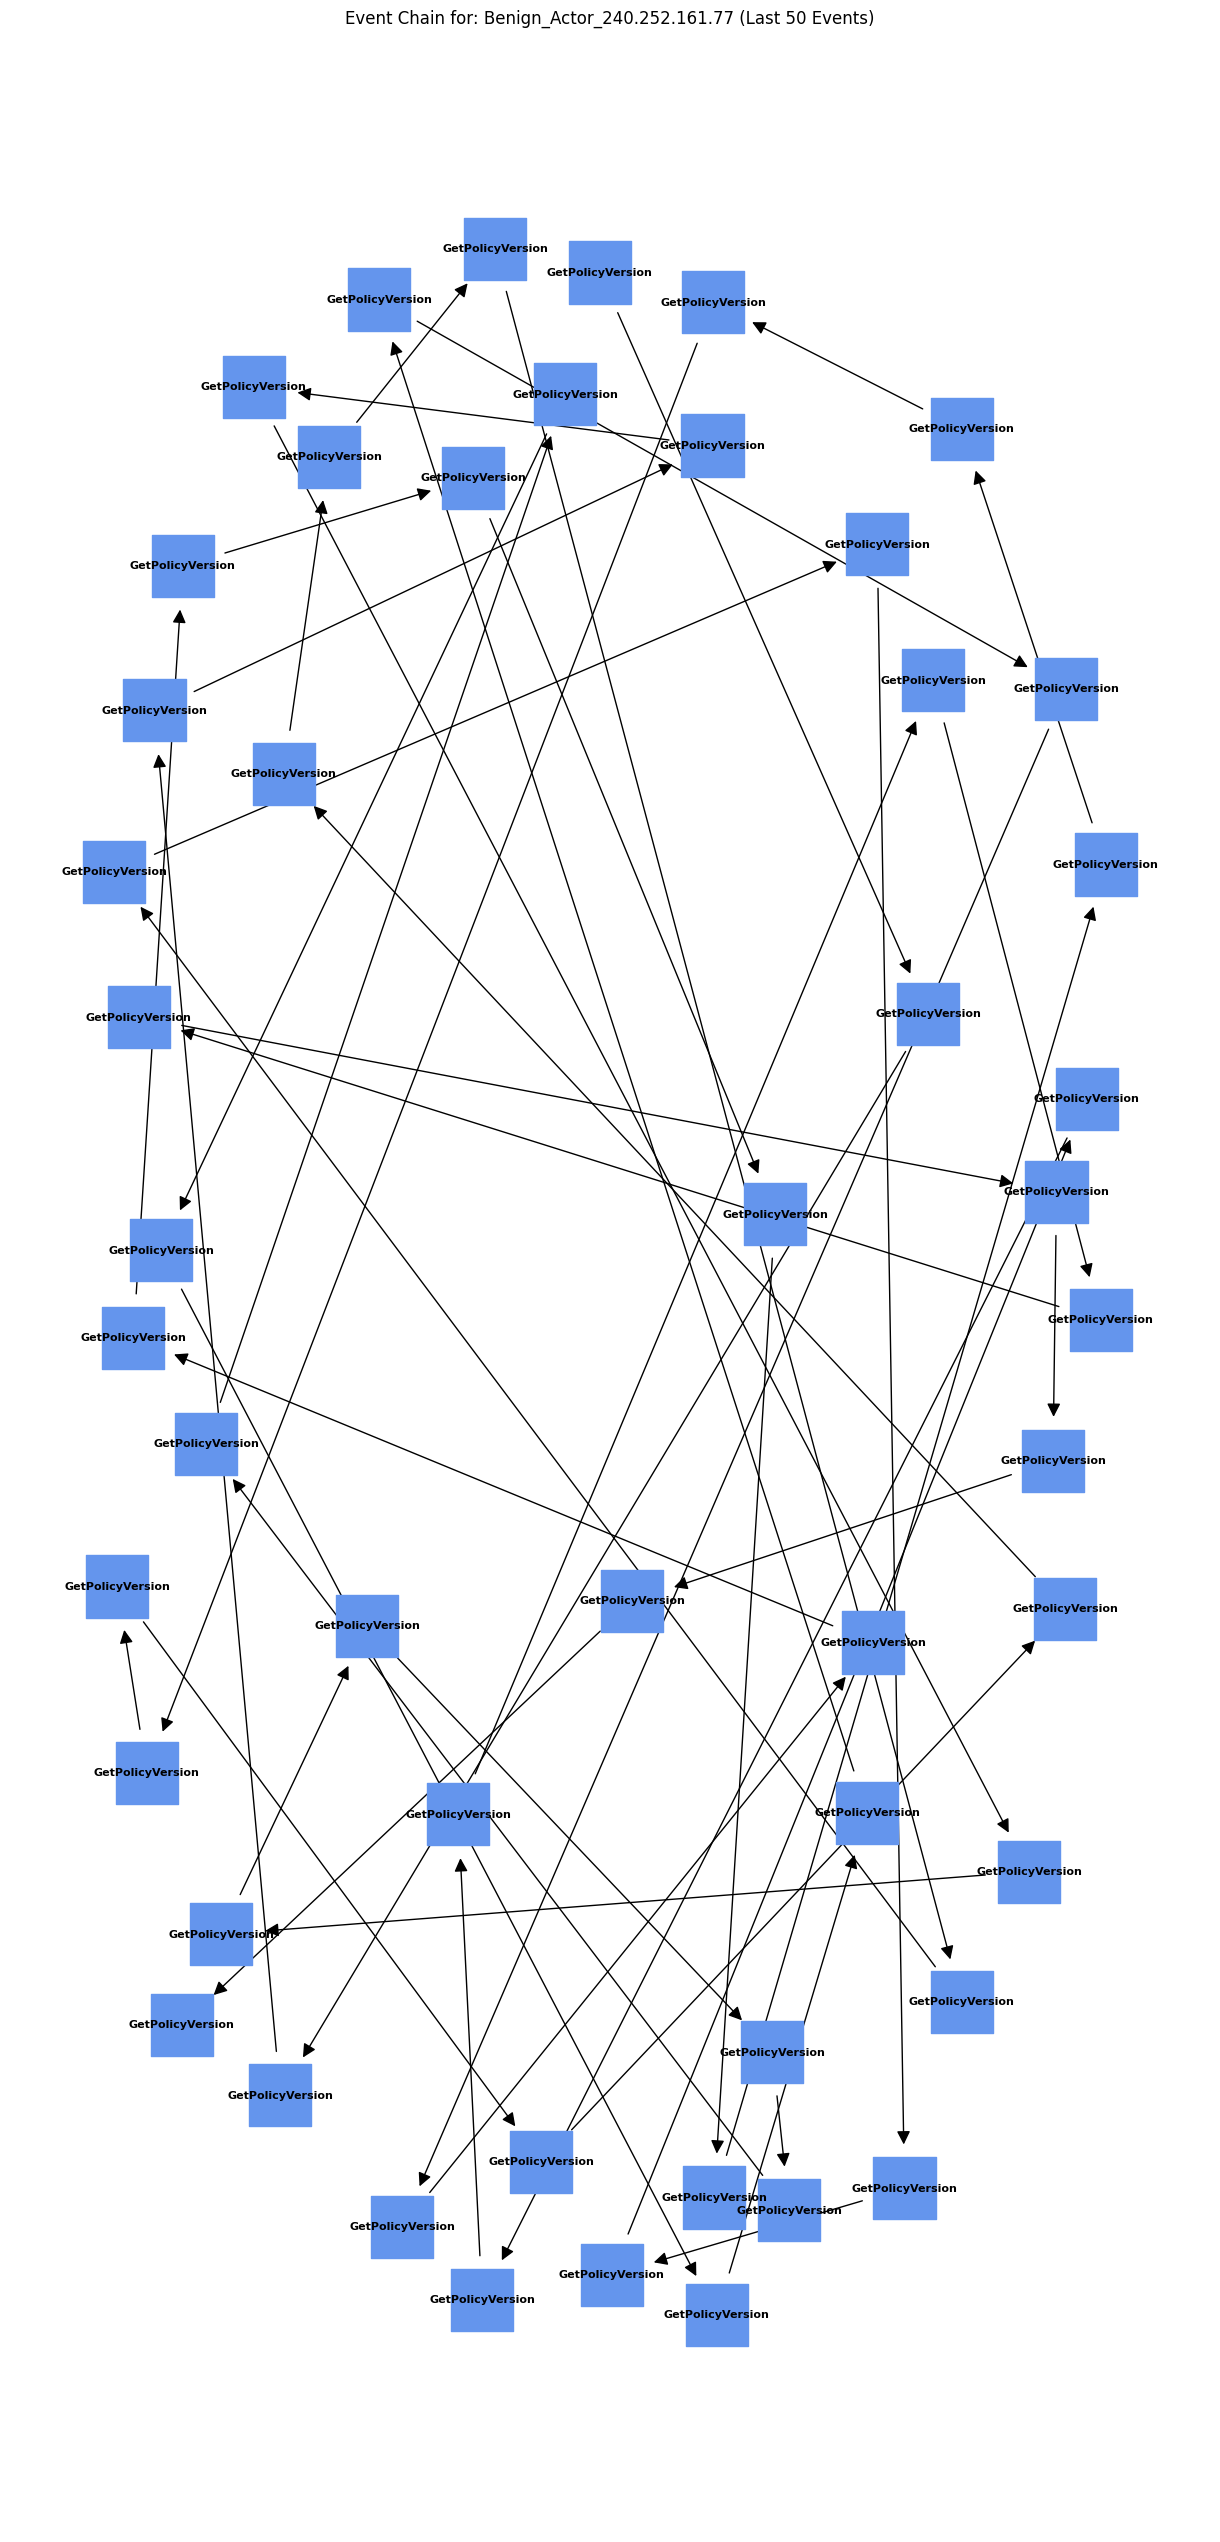


--- Analysis Complete ---
Generated 6 individual actor timeline graphs.


In [5]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import warnings

# Suppress warnings
warnings.filterwarnings('ignore', category=UserWarning)

# --- 1. Load the Balanced ML Dataset ---
csv_file = 'final_ml_training_dataset.csv'
print(f"Loading balanced ML dataset from '{csv_file}'...")

columns_to_load = ['eventTime', 'event_name', 'sourceIPAddress', 'label']

try:
    df_ml = pd.read_csv(csv_file, usecols=columns_to_load, parse_dates=['eventTime'])
    df_ml.fillna('missing', inplace=True)
    print(f"Successfully loaded {len(df_ml)} events.")
except FileNotFoundError:
    print(f"Error: File '{csv_file}' not found.")
    df_ml = pd.DataFrame()
except Exception as e:
    print(f"Error loading file: {e}")
    df_ml = pd.DataFrame()

if not df_ml.empty:

    # --- 2. Find Top 3 Malicious and Benign Actors ---
    print("\n--- Identifying Top Actors for Analysis ---")

    malicious_ips_counts = df_ml[df_ml['label'] == 1]['sourceIPAddress'].value_counts()
    top_malicious_ips = malicious_ips_counts.head(3).index.tolist()
    print(f"Top 3 Malicious Actors: {top_malicious_ips}")

    benign_ips_counts = df_ml[df_ml['label'] == 0]['sourceIPAddress'].value_counts()
    top_benign_ips = benign_ips_counts.head(3).index.tolist()
    print(f"Top 3 Benign Actors: {top_benign_ips}")

    # --- 3. Define the Graphing Function (with FIX) ---
    def create_actor_timeline_graph(df_actor, title, max_events_to_plot=50):
        """
        Creates and visualizes a chronological event graph for a single actor's DataFrame.
        Plots ONLY the most recent 'max_events_to_plot' events to prevent errors.
        """
        if df_actor.empty:
            print(f"No data for {title}, skipping graph.")
            return None

        # Sort by time
        df_actor = df_actor.sort_values('eventTime')
        
        # --- THIS IS THE FIX ---
        # If the actor has too many events, take only the most recent ones.
        if len(df_actor) > max_events_to_plot:
            print(f"  (Actor has {len(df_actor)} events. Plotting only the last {max_events_to_plot}.)")
            df_actor_sample = df_actor.tail(max_events_to_plot)
        else:
            df_actor_sample = df_actor
        
        G = nx.DiGraph()
        node_labels = {}
        node_colors = {}
        
        # Loop through the (potentially sampled) DataFrame
        for i in range(len(df_actor_sample)):
            current_event = df_actor_sample.iloc[i]
            node_id = current_event.name
            
            G.add_node(node_id)
            node_labels[node_id] = current_event['event_name']
            node_colors[node_id] = 'red' if current_event['label'] == 1 else 'cornflowerblue'
            
            if i > 0:
                previous_event_node_id = df_actor_sample.iloc[i-1].name
                G.add_edge(previous_event_node_id, node_id)
                
        # --- Visualize the Graph ---
        # Calculate a reasonable plot height
        plot_height = max(5, min(len(df_actor_sample) * 0.5, 25)) # Max height of 25 inches
        plt.figure(figsize=(12, plot_height))
        
        try:
            pos = nx.nx_pydot.graphviz_layout(G, prog='dot')
            print(f"  (Using 'dot' layout for {title})")
        except:
            print(f"  (Graphviz/pydot not found, using 'spring' layout for {title}.)")
            pos = nx.spring_layout(G, k=0.8, iterations=20, seed=42)
        
        colors = [node_colors[node] for node in G.nodes()]

        nx.draw(
            G, pos,
            node_color=colors, labels=node_labels,
            with_labels=True, node_size=2000,
            font_size=8, font_weight='bold',
            arrows=True, arrowsize=20, node_shape='s'
        )
        
        safe_title = title.replace(':', '_').replace('/', '_') # Clean title for filename
        plt.title(f"Event Chain for: {title} (Last {len(df_actor_sample)} Events)")
        plt.savefig(f"event_chain_{safe_title}.png")
        plt.show()
        
        return G

    print("\nGraphing function `create_actor_timeline_graph` defined.")

    # --- 4. Loop and Analyze Malicious Actors ---
    print("\n--- Generating Malicious Event Chains ---")
    for ip in top_malicious_ips:
        print(f"\nAnalyzing Malicious Actor: {ip}")
        df_malicious_actor = df_ml[df_ml['sourceIPAddress'] == ip]
        G_malicious = create_actor_timeline_graph(
            df_malicious_actor, 
            f"Malicious_Actor_{ip}"
        )

    # --- 5. Loop and Analyze Benign Actors ---
    print("\n--- Generating Benign Event Chains ---")
    for ip in top_benign_ips:
        print(f"\nAnalyzing Benign Actor: {ip}")
        df_benign_actor = df_ml[df_ml['sourceIPAddress'] == ip]
        G_benign = create_actor_timeline_graph(
            df_benign_actor, 
            f"Benign_Actor_{ip}"
        )

    print("\n--- Analysis Complete ---")
    print(f"Generated {len(top_malicious_ips) + len(top_benign_ips)} individual actor timeline graphs.")

else:
    print("Cannot proceed with analysis as DataFrame 'df_ml' was not loaded.")

In [ ]:
# --- Analyze Benign Actor ---
if 'target_benign_ip' in globals():
    print(f"\n--- Generating Benign Event Chain for IP: {target_benign_ip} ---")
    
    # 1. Filter the main DataFrame for ONLY this IP's events
    df_benign_actor = df_ml[df_ml['sourceIPAddress'] == target_benign_ip]
    
    # 2. Create the timeline graph
    G_benign = create_actor_timeline_graph(
        df_benign_actor, 
        f"Benign Actor ({target_benign_ip})"
    )
else:
    print("Benign actor not defined. Please run Cell 1 first.")

Graphing function `create_actor_timeline_graph` defined.

Loading balanced ML dataset from 'final_ml_training_dataset.csv'...
Successfully loaded 487606 events.

--- Identifying Top Actors for Analysis ---
Top 3 Malicious Actors: ['ec2.amazonaws.com', '193.29.252.218', '253.0.255.253']
Top 3 Benign Actors: ['5.205.62.253', '255.253.125.115', '240.252.161.77']

--- Generating Malicious Event Chains ---

Analyzing Malicious Actor: ec2.amazonaws.com
  (Actor has 43555 events. Plotting only the last 25.)
  (Graphviz/pydot not found, using 'spring' layout for Malicious_Actor_ec2.amazonaws.com.)
  For a clearer top-to-bottom graph, run: pip install graphviz pydot


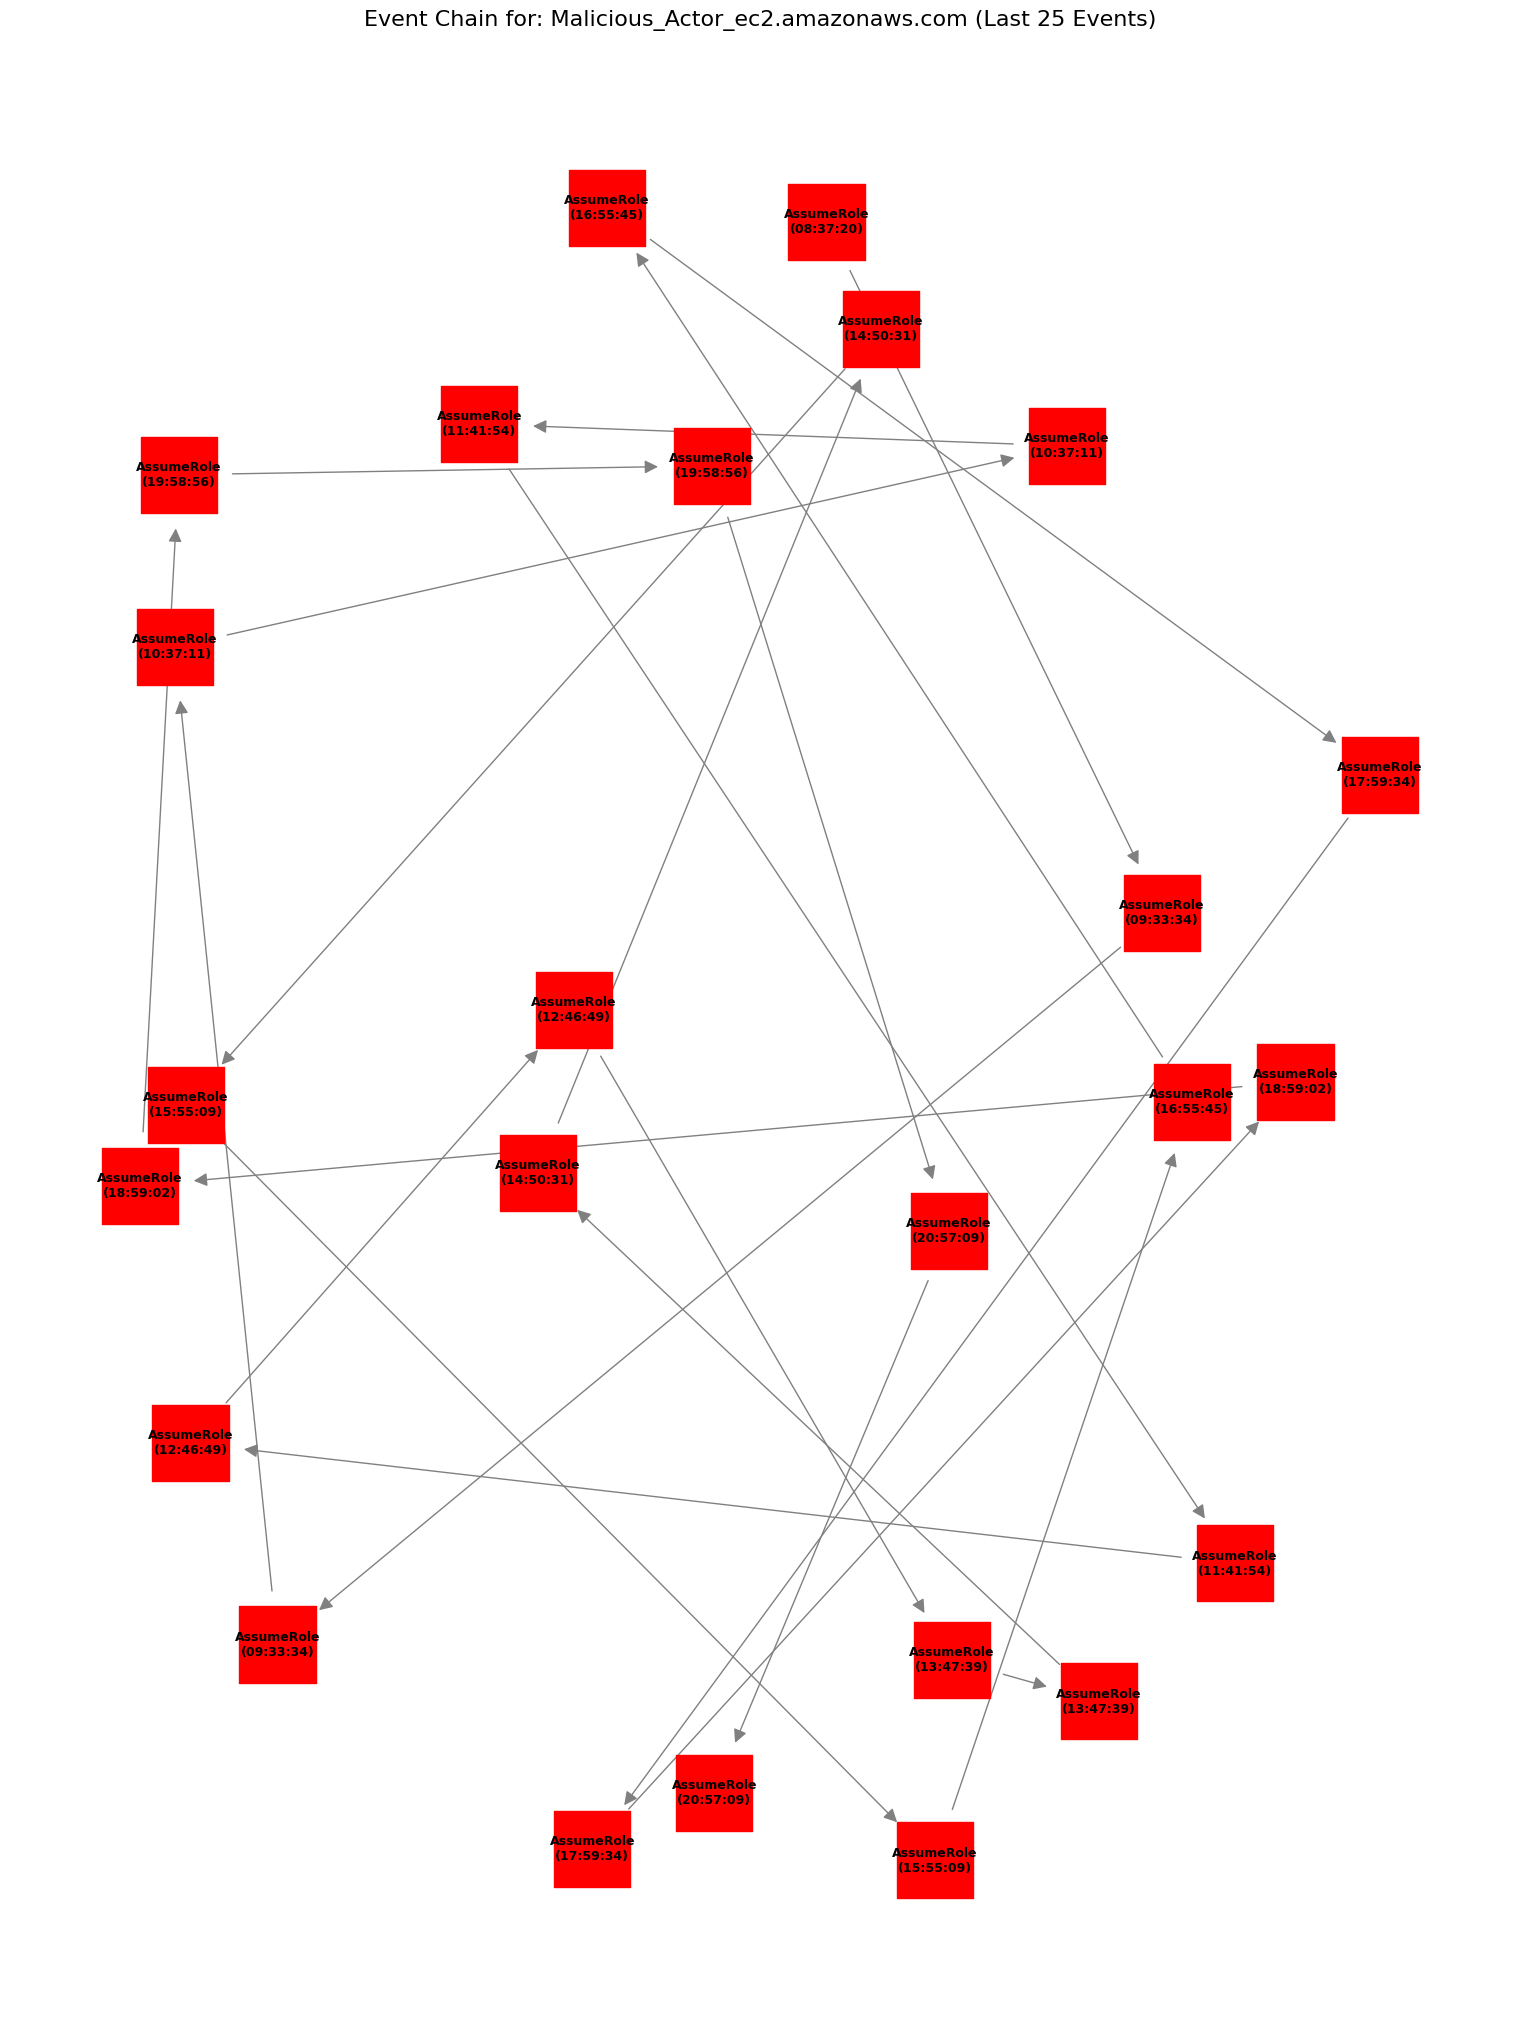


Analyzing Malicious Actor: 193.29.252.218
  (Actor has 23479 events. Plotting only the last 25.)
  (Graphviz/pydot not found, using 'spring' layout for Malicious_Actor_193.29.252.218.)
  For a clearer top-to-bottom graph, run: pip install graphviz pydot


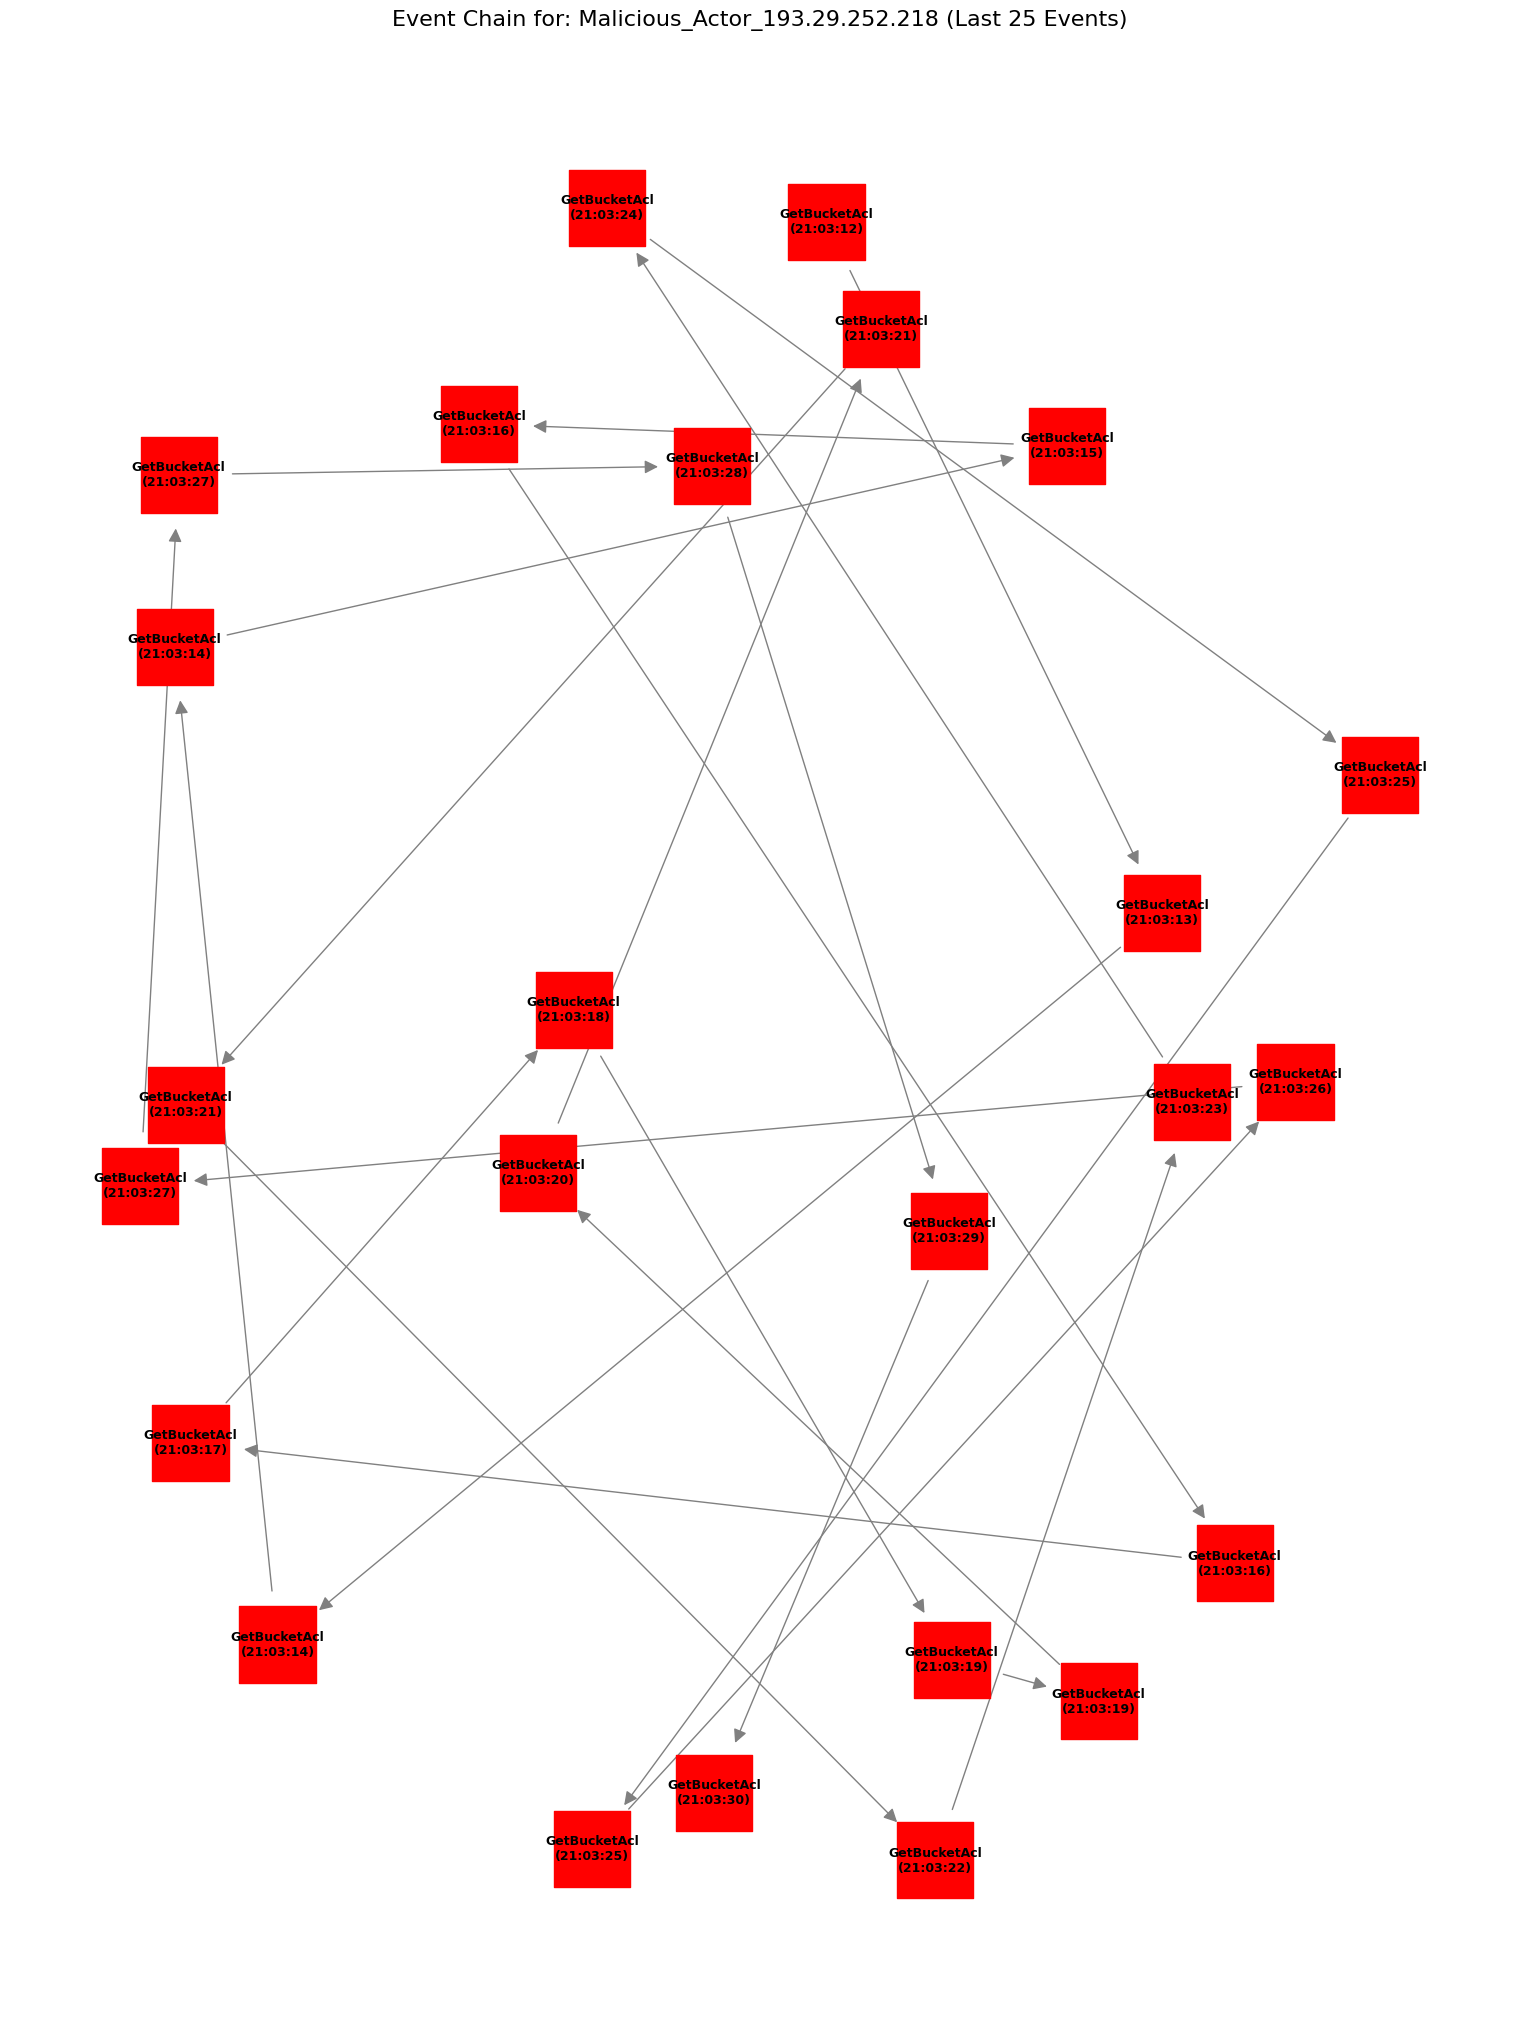


Analyzing Malicious Actor: 253.0.255.253
  (Actor has 9067 events. Plotting only the last 25.)
  (Graphviz/pydot not found, using 'spring' layout for Malicious_Actor_253.0.255.253.)
  For a clearer top-to-bottom graph, run: pip install graphviz pydot


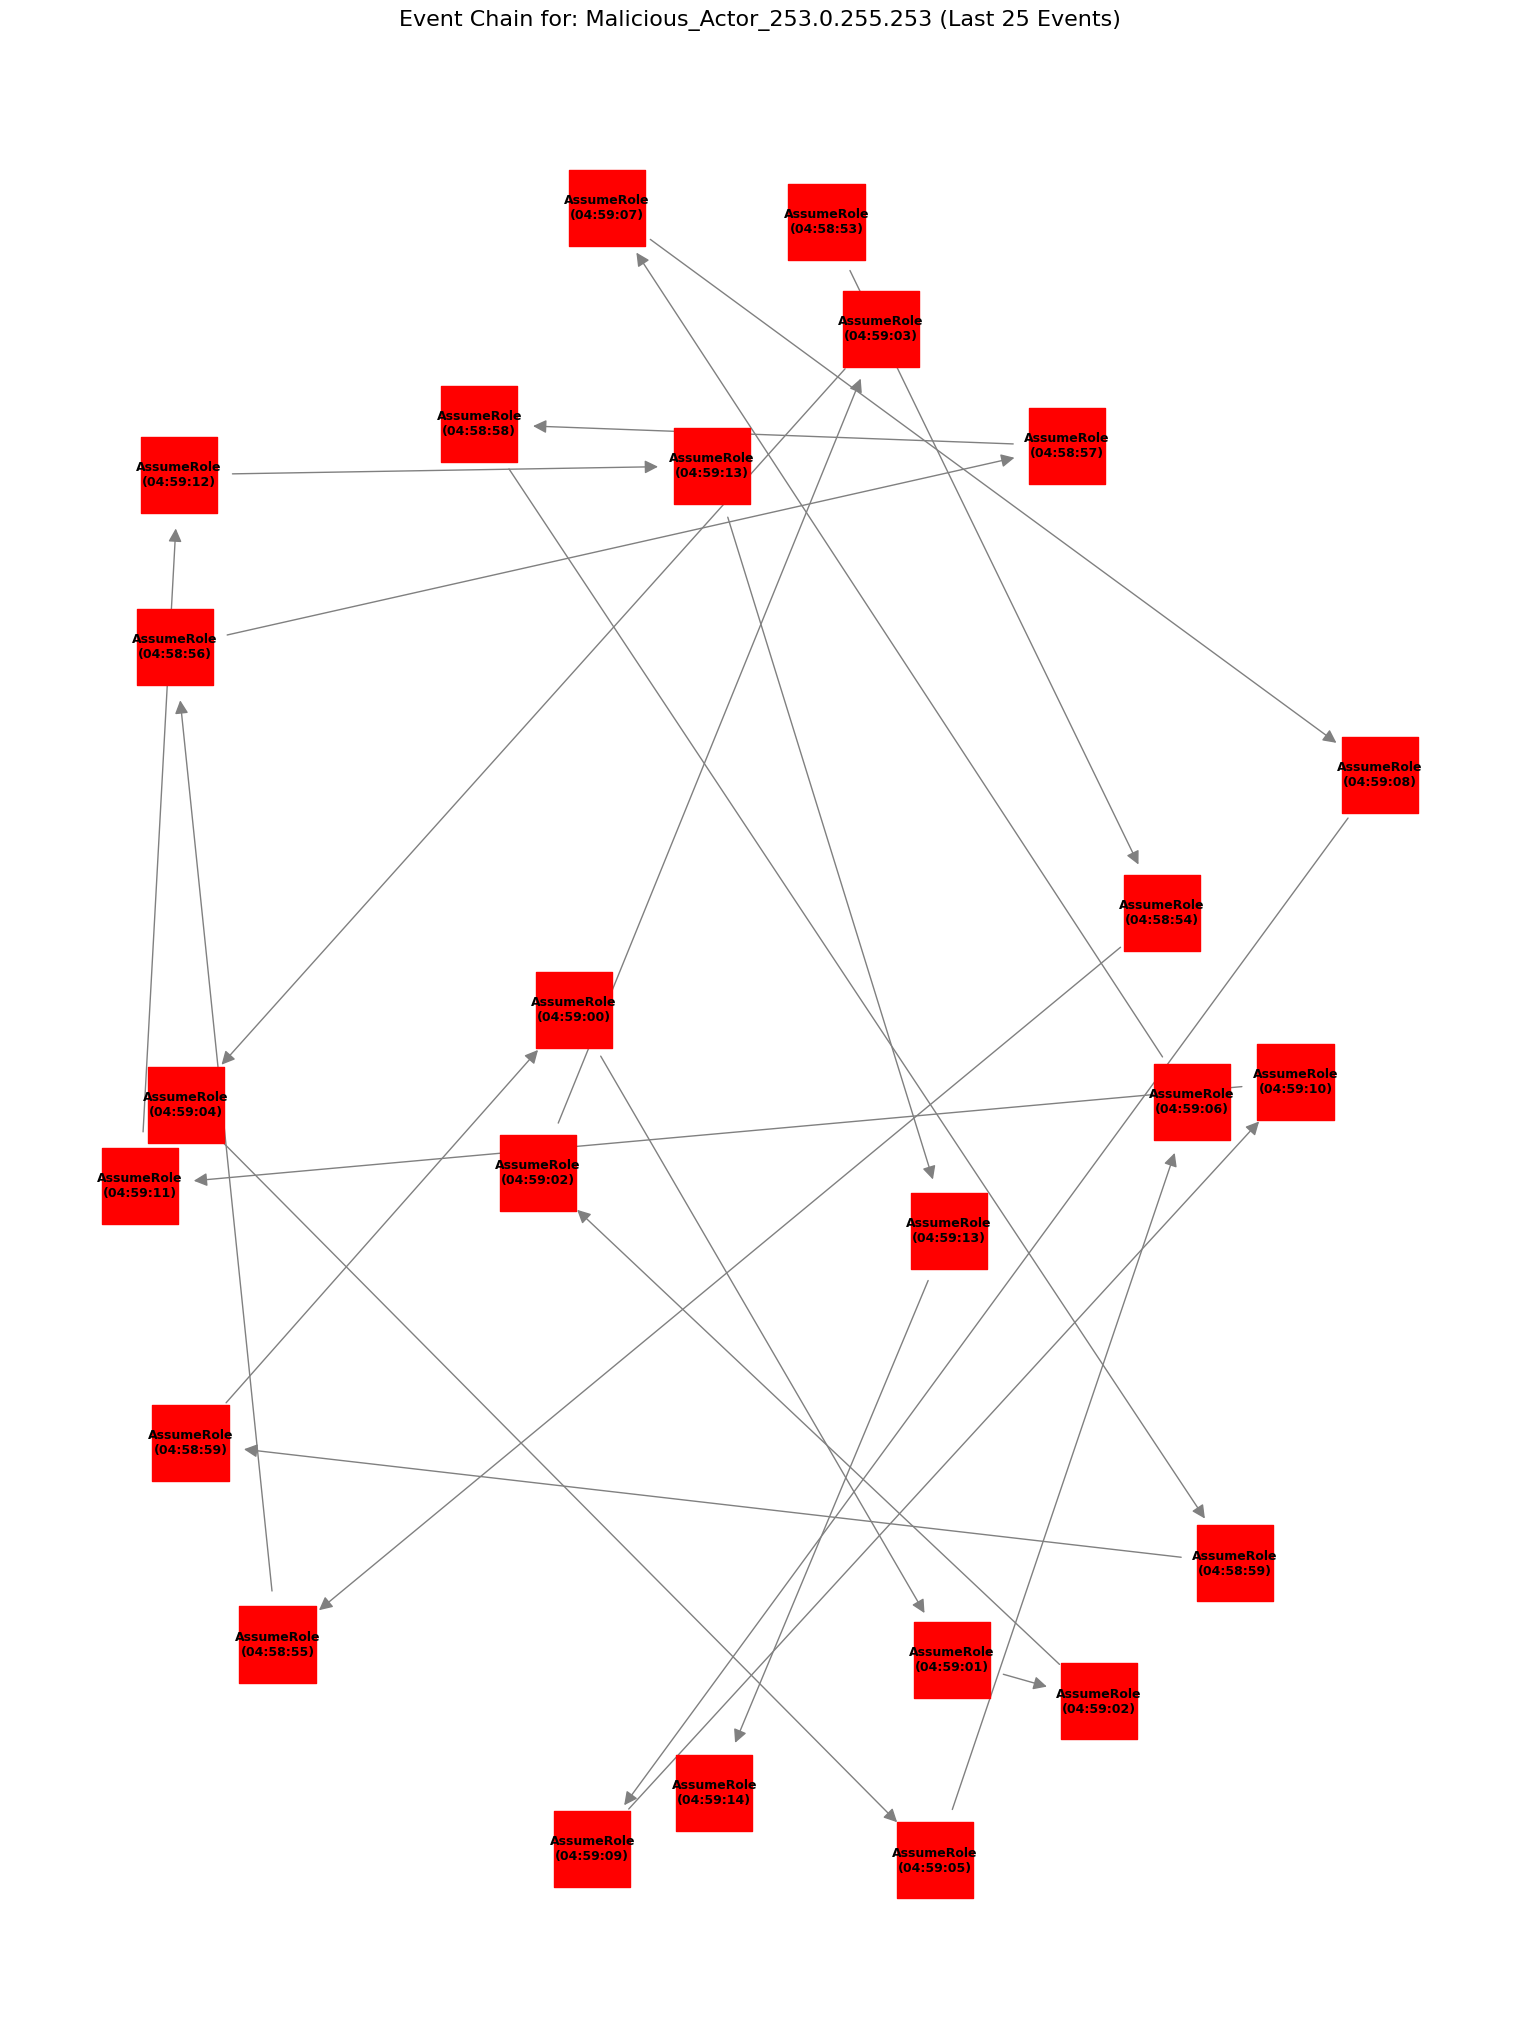


--- Generating Benign Event Chains ---

Analyzing Benign Actor: 5.205.62.253
  (Actor has 179995 events. Plotting only the last 25.)
  (Graphviz/pydot not found, using 'spring' layout for Benign_Actor_5.205.62.253.)
  For a clearer top-to-bottom graph, run: pip install graphviz pydot


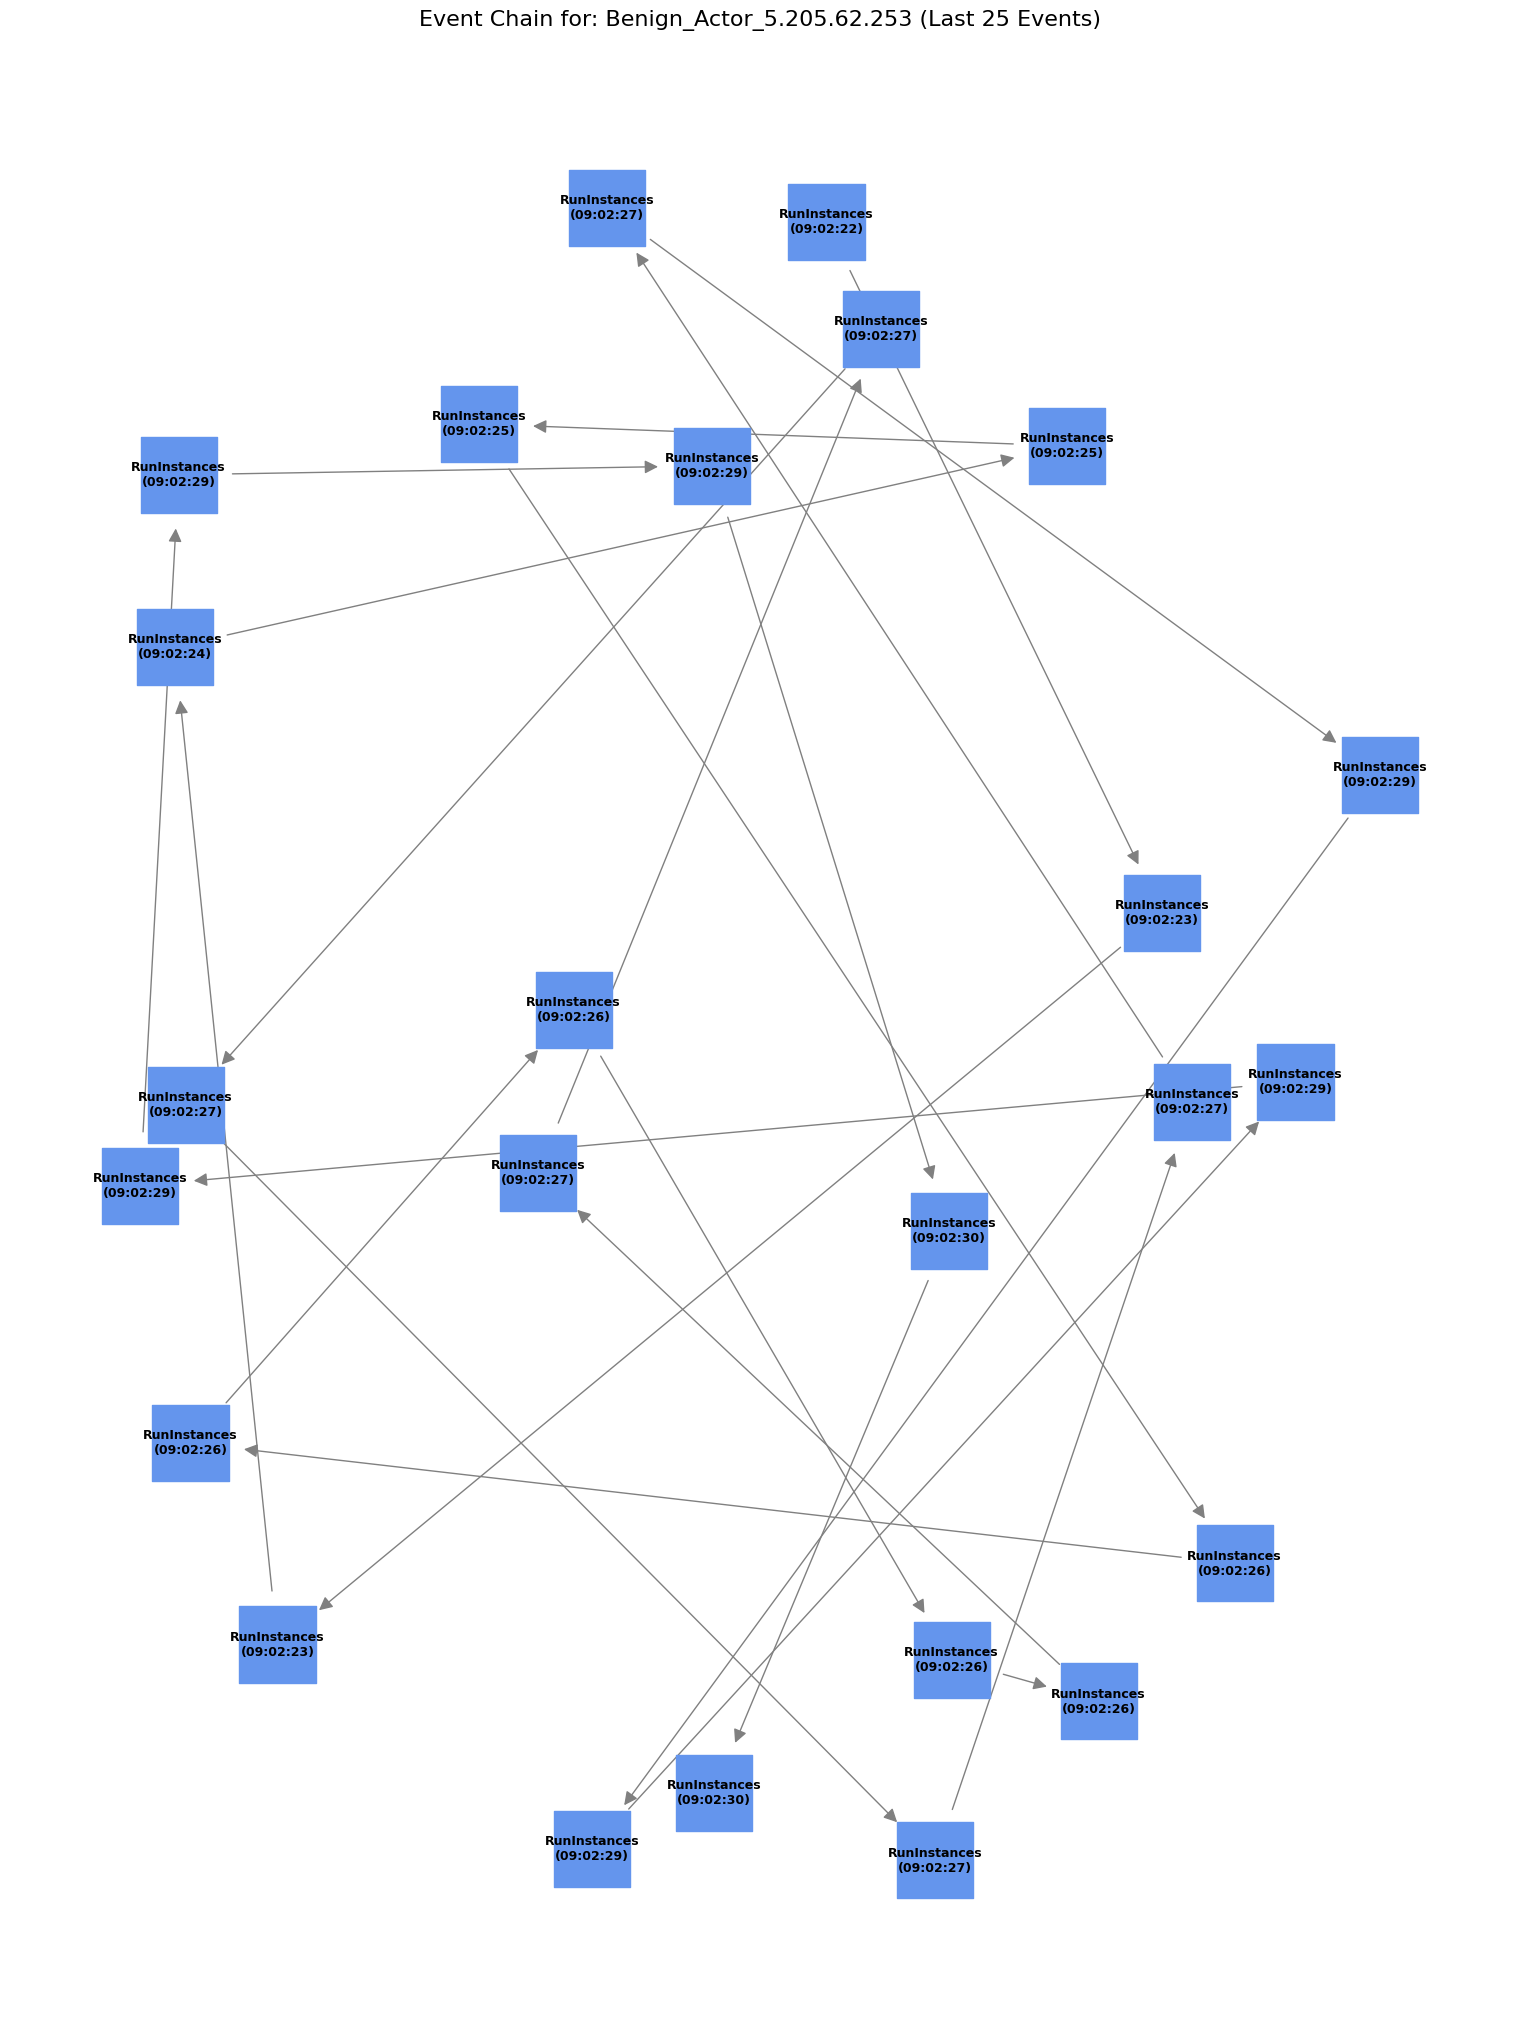


Analyzing Benign Actor: 255.253.125.115
  (Actor has 12272 events. Plotting only the last 25.)
  (Graphviz/pydot not found, using 'spring' layout for Benign_Actor_255.253.125.115.)
  For a clearer top-to-bottom graph, run: pip install graphviz pydot


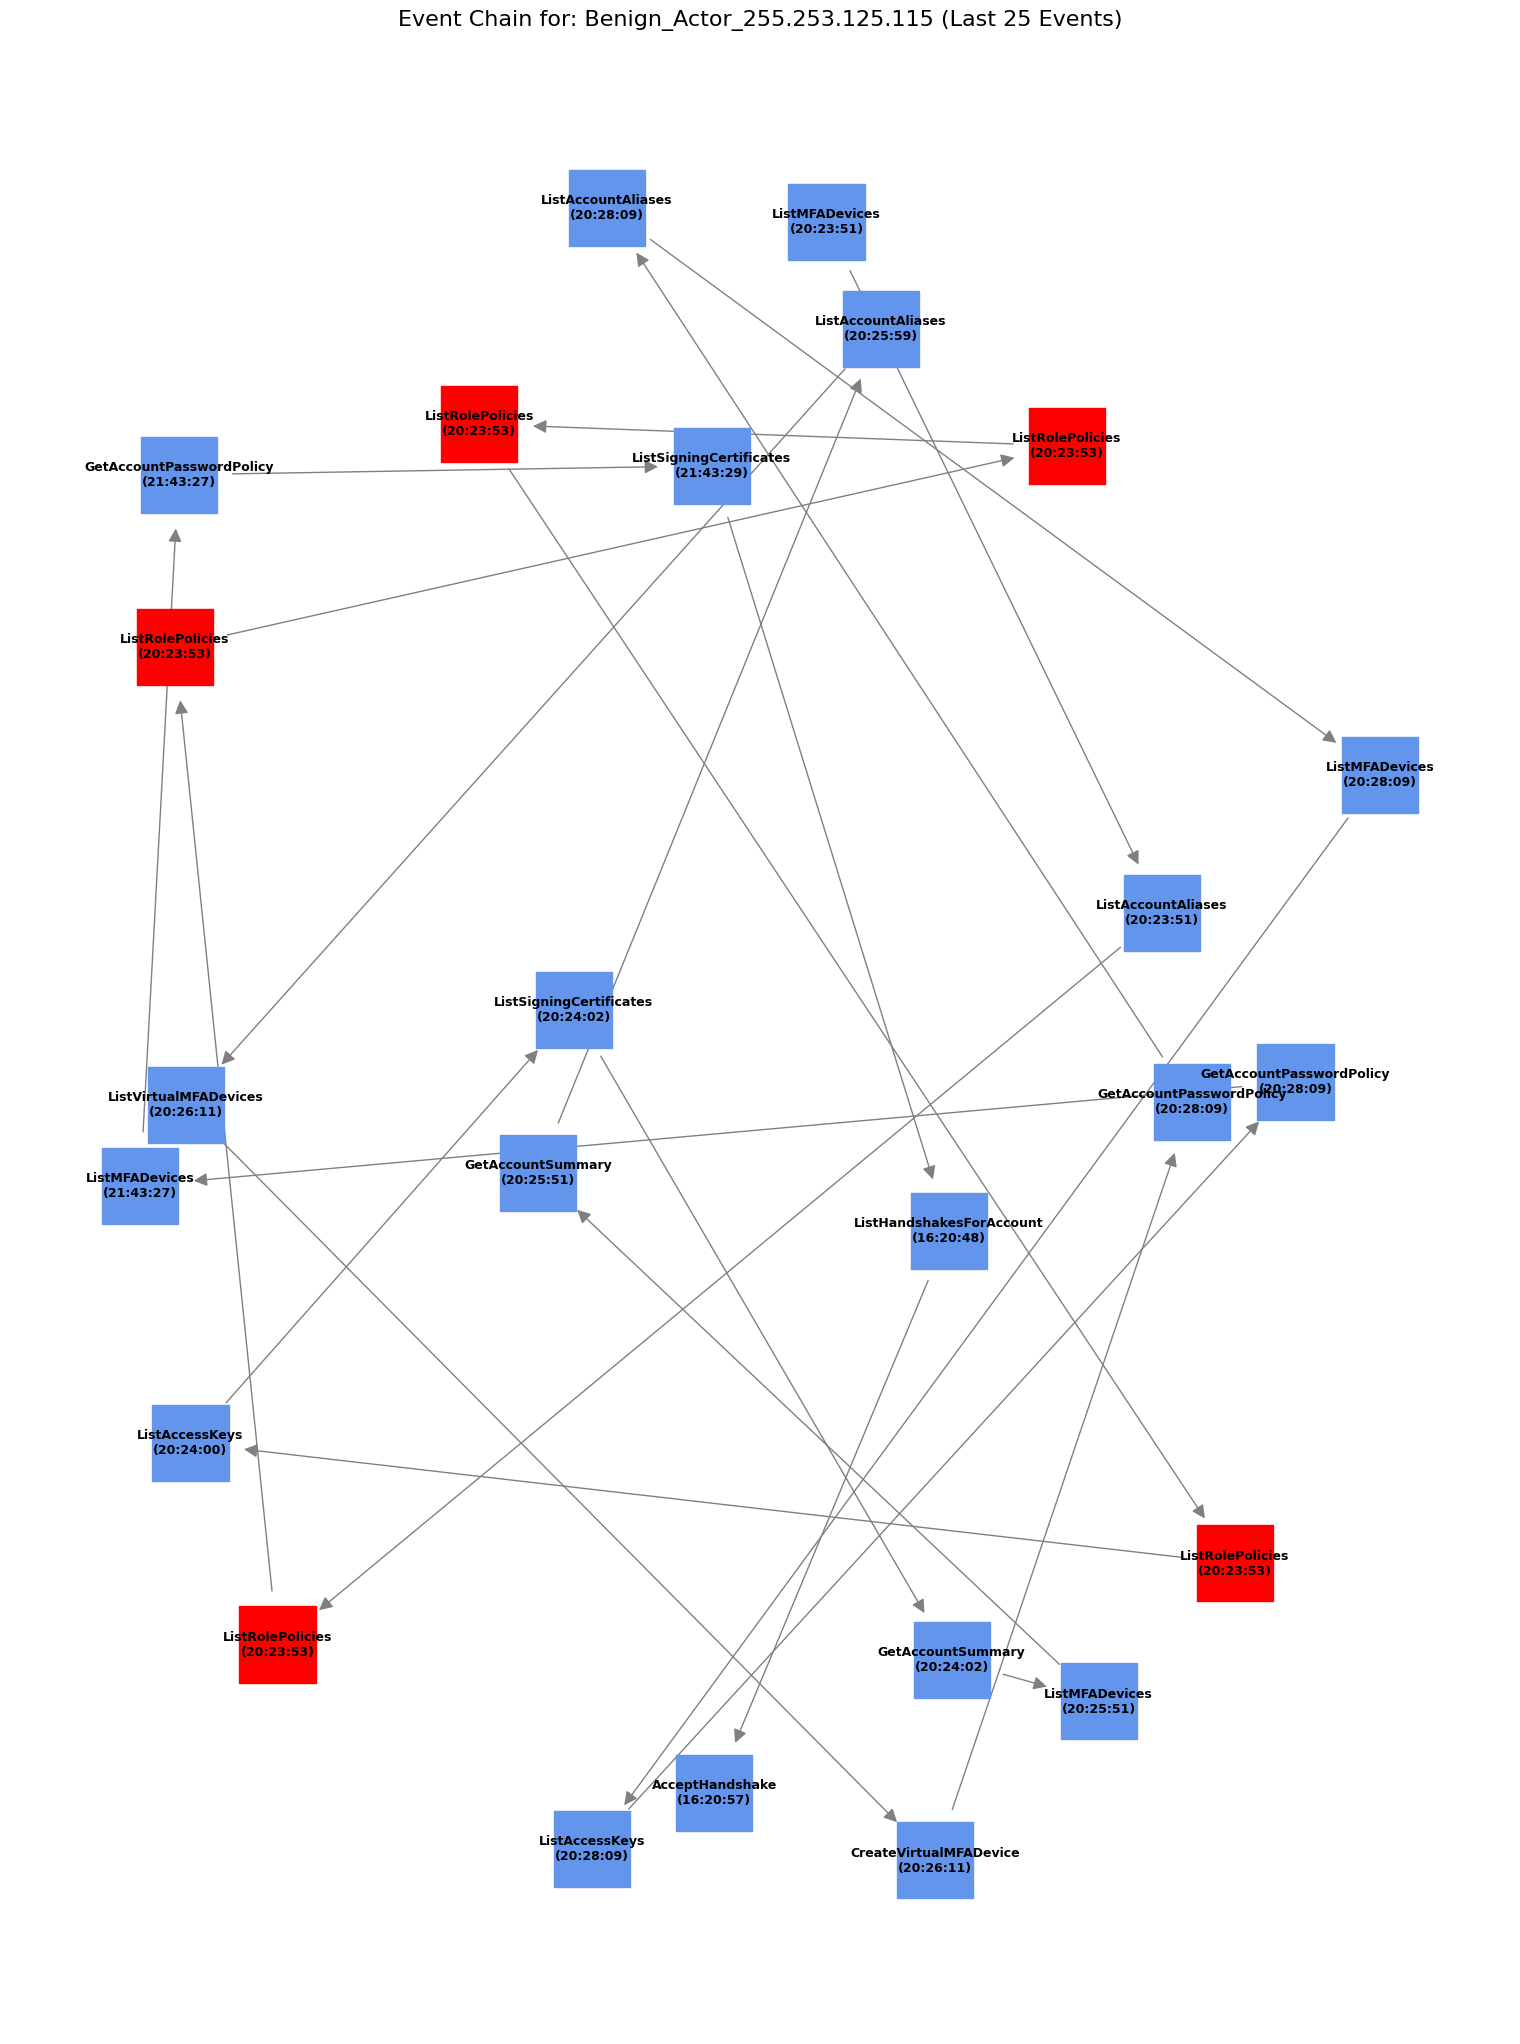


Analyzing Benign Actor: 240.252.161.77
  (Actor has 6690 events. Plotting only the last 25.)
  (Graphviz/pydot not found, using 'spring' layout for Benign_Actor_240.252.161.77.)
  For a clearer top-to-bottom graph, run: pip install graphviz pydot


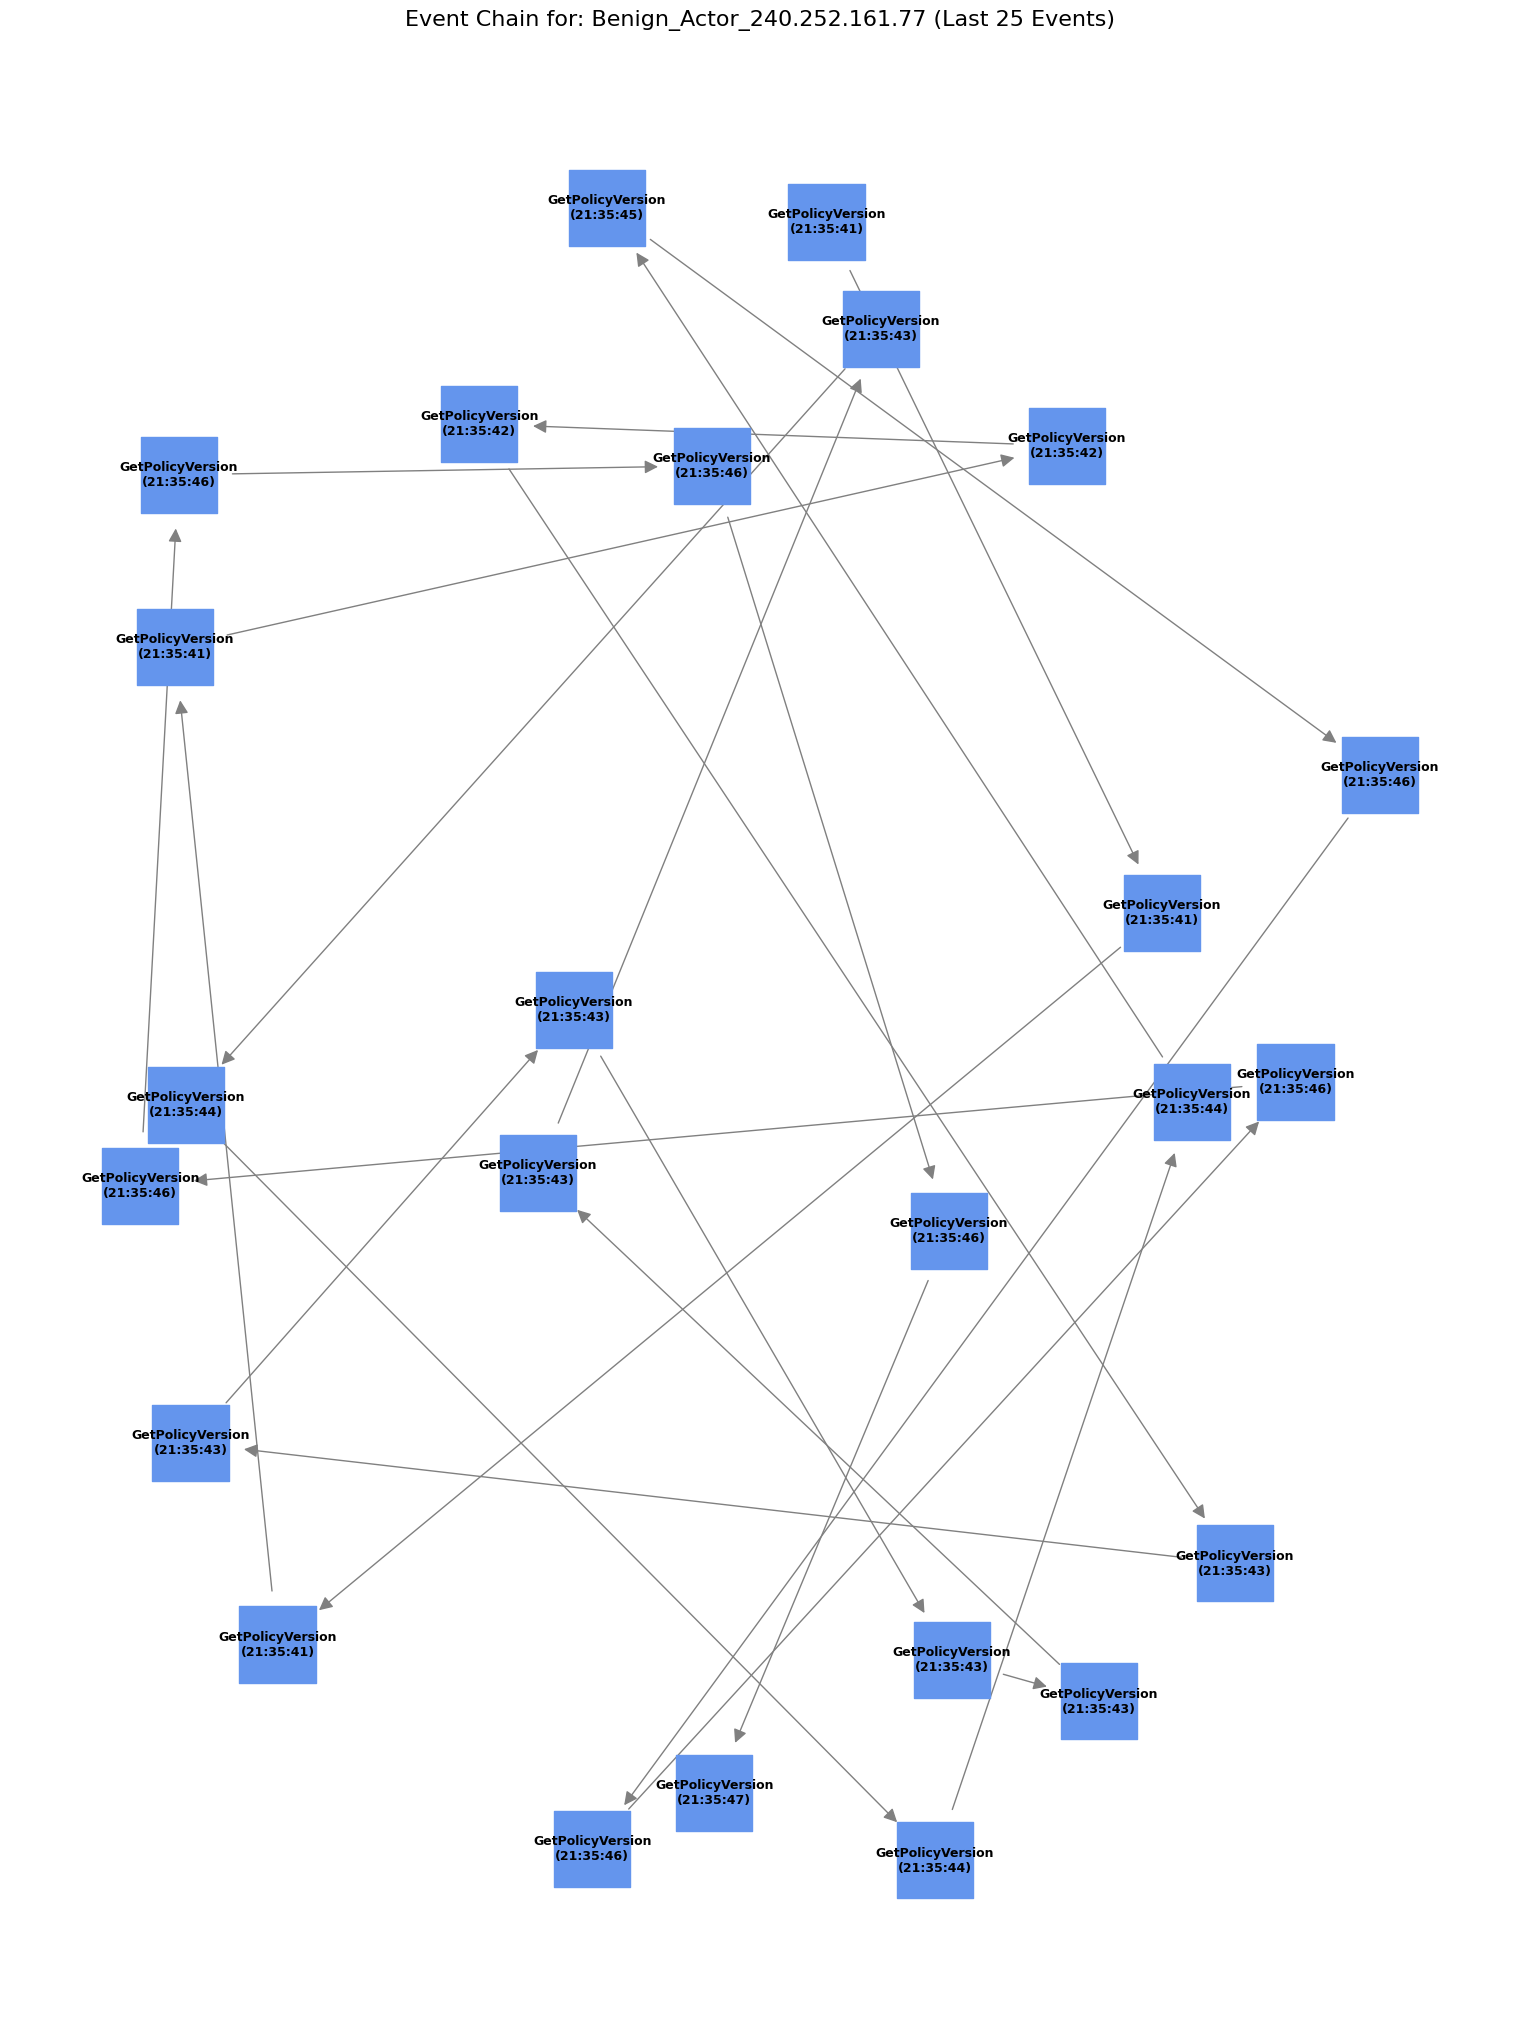


--- Analysis Complete ---
Generated 6 individual actor timeline graphs.


In [6]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import warnings

# Suppress warnings for a cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)


# --- 1. Define the NEW Graphing Function ---
def create_actor_timeline_graph(df_actor, title, max_events_to_plot=25):
    """
    Creates and visualizes a readable, chronological event graph.
    Plots ONLY the most recent 'max_events_to_plot' events.
    """
    if df_actor.empty:
        print(f"No data for {title}, skipping graph.")
        return None

    # Sort by time
    df_actor = df_actor.sort_values('eventTime')
    
    # --- FIX for ValueError: Limit the number of events ---
    if len(df_actor) > max_events_to_plot:
        print(f"  (Actor has {len(df_actor)} events. Plotting only the last {max_events_to_plot}.)")
        df_actor_sample = df_actor.tail(max_events_to_plot)
    else:
        df_actor_sample = df_actor
    
    G = nx.DiGraph()
    node_labels = {}
    node_colors = {}
    
    # Loop through the (potentially sampled) DataFrame
    for i in range(len(df_actor_sample)):
        current_event = df_actor_sample.iloc[i]
        node_id = current_event.name 
        
        G.add_node(node_id)
        
        # --- NEW: Make labels more informative ---
        event_name = current_event.get('event_name', 'Unknown')
        event_time_str = ""
        # Check if timestamp is valid before formatting
        if pd.notna(current_event['eventTime']):
            event_time_str = current_event['eventTime'].strftime('%H:%M:%S')
        
        # Create a multi-line label
        node_labels[node_id] = f"{event_name}\n({event_time_str})"
        
        node_colors[node_id] = 'red' if current_event['label'] == 1 else 'cornflowerblue'
        
        if i > 0:
            previous_event_node_id = df_actor_sample.iloc[i-1].name
            G.add_edge(previous_event_node_id, node_id)
            
    # --- Visualize the Graph ---
    plot_height = max(8, len(df_actor_sample) * 0.8) # Taller plot for readability
    plt.figure(figsize=(15, plot_height))
    
    # --- NEW: Try to use a top-to-bottom 'dot' layout ---
    # This makes timelines much easier to read.
    # Requires graphviz and pydot to be installed in your environment
    try:
        pos = nx.nx_pydot.graphviz_layout(G, prog='dot')
        print(f"  (Using 'dot' layout for {title})")
    except:
        print(f"  (Graphviz/pydot not found, using 'spring' layout for {title}.)")
        print("  For a clearer top-to-bottom graph, run: pip install graphviz pydot")
        pos = nx.spring_layout(G, k=0.8, iterations=20, seed=42)
    
    colors = [node_colors[node] for node in G.nodes()]
    node_sizes = [3000 for node in G.nodes()] # Large nodes for labels

    nx.draw(
        G, pos,
        node_color=colors, 
        labels=node_labels,
        with_labels=True, 
        node_size=node_sizes,
        font_size=9, 
        font_weight='bold',
        arrows=True, 
        arrowsize=20, 
        node_shape='s', # Use squares
        edge_color='gray'
    )
    
    safe_title = title.replace(':', '_').replace('/', '_') # Clean title for filename
    plt.title(f"Event Chain for: {title} (Last {len(df_actor_sample)} Events)", fontsize=16)
    plt.savefig(f"event_chain_{safe_title}.png")
    plt.show()
    
    return G

print("Graphing function `create_actor_timeline_graph` defined.")

# --- 2. Load the Balanced ML Dataset ---
csv_file = 'final_ml_training_dataset.csv'
print(f"\nLoading balanced ML dataset from '{csv_file}'...")

columns_to_load = ['eventTime', 'event_name', 'sourceIPAddress', 'label']

try:
    df_ml = pd.read_csv(csv_file, usecols=columns_to_load, parse_dates=['eventTime'])
    df_ml.fillna('missing', inplace=True) 
    print(f"Successfully loaded {len(df_ml)} events.")
except FileNotFoundError:
    print(f"Error: File '{csv_file}' not found.")
    df_ml = pd.DataFrame()
except Exception as e:
    print(f"Error loading file: {e}")

# --- 3. Analyze Top Malicious and Benign Actors ---
if not df_ml.empty:
    print("\n--- Identifying Top Actors for Analysis ---")

    # Find Top 3 "Malicious" IPs (label=1) by event count
    malicious_ips_counts = df_ml[df_ml['label'] == 1]['sourceIPAddress'].value_counts()
    top_malicious_ips = malicious_ips_counts.head(3).index.tolist()
    print(f"Top 3 Malicious Actors: {top_malicious_ips}")

    # Find Top 3 "Benign" IPs (label=0) by event count
    benign_ips_counts = df_ml[df_ml['label'] == 0]['sourceIPAddress'].value_counts()
    top_benign_ips = benign_ips_counts.head(3).index.tolist()
    print(f"Top 3 Benign Actors: {top_benign_ips}")

    # --- 4. Loop and Analyze Malicious Actors ---
    print("\n--- Generating Malicious Event Chains ---")
    for ip in top_malicious_ips:
        print(f"\nAnalyzing Malicious Actor: {ip}")
        df_malicious_actor = df_ml[df_ml['sourceIPAddress'] == ip]
        G_malicious = create_actor_timeline_graph(
            df_malicious_actor, 
            f"Malicious_Actor_{ip}"
        )

    # --- 5. Loop and Analyze Benign Actors ---
    print("\n--- Generating Benign Event Chains ---")
    for ip in top_benign_ips:
        print(f"\nAnalyzing Benign Actor: {ip}")
        df_benign_actor = df_ml[df_ml['sourceIPAddress'] == ip]
        G_benign = create_actor_timeline_graph(
            df_benign_actor, 
            f"Benign_Actor_{ip}"
        )

    print("\n--- Analysis Complete ---")
    print(f"Generated {len(top_malicious_ips) + len(top_benign_ips)} individual actor timeline graphs.")
else:
    print("Cannot proceed with analysis as DataFrame 'df_ml' was not loaded.")

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import time

# --- Import the Models ---
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
try:
    from xgboost import XGBClassifier
    xgboost_available = True
except ImportError:
    print("XGBoost not found. Run 'pip install xgboost' to include it.")
    xgboost_available = False

# --- 1. Load Your 50/50 Balanced "Ground Truth" Dataset ---
csv_file = 'final_ml_training_dataset.csv'
print(f"Loading balanced ML dataset from '{csv_file}'...")

# We need eventTime to create non-leaky features
columns_to_load = ['eventTime', 'sourceIPAddress', 'userIdentity.arn', 'label']

try:
    df_ml = pd.read_csv(csv_file, usecols=columns_to_load)
    print(f"Successfully loaded {len(df_ml)} events.")
except FileNotFoundError:
    print(f"ERROR: File '{csv_file}' not found. Please ensure it's in the same directory.")
    df_ml = pd.DataFrame()
except Exception as e:
    print(f"Error loading CSV: {e}")

if not df_ml.empty:

    # --- 2. Create Non-Leaky Features ---
    print("Creating time-based (non-leaky) features...")
    df_ml['eventTime'] = pd.to_datetime(df_ml['eventTime'], errors='coerce')
    df_ml['hour_of_day'] = df_ml['eventTime'].dt.hour
    df_ml['day_of_week'] = df_ml['eventTime'].dt.dayofweek

    # --- 3. Define Features (X) and Target (y) (NON-LEAKY) ---
    print("Preparing features and target (excluding 'event_name')...")

    # 'event_name' is REMOVED from features to prevent data leakage
    categorical_features = ['sourceIPAddress', 'userIdentity.arn']
    numerical_features = ['hour_of_day', 'day_of_week']

    # Handle missing values
    df_ml[categorical_features] = df_ml[categorical_features].fillna('missing')
    df_ml[numerical_features] = df_ml[numerical_features].fillna(0)

    X = df_ml[categorical_features + numerical_features]
    y = df_ml['label'] # The 'label' column (0 or 1)

    # --- 4. Create Preprocessor (Memory-Safe) ---
    preprocessor = ColumnTransformer(
        transformers=[
            # Use default sparse=True for OneHotEncoder
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('num', StandardScaler(), numerical_features)
        ])

    # --- 5. Split the Data ---
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    print(f"Data split into {len(X_train)} training and {len(X_test)} testing samples.")

    # --- 6. Define Models to Compare ---
    models_to_compare = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1)
    }
    if xgboost_available:
        models_to_compare['XGBoost'] = XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss')

    # --- 7. Train and Evaluate Each Model ---
    print("\nTraining and evaluating models on non-leaky features... (This may take some time)")
    performance_results = {}

    for name, model in models_to_compare.items():
        print(f"--- Testing: {name} ---")
        start_time = time.time()
        
        pipeline = Pipeline(steps=[
            ('preprocess', preprocessor),
            ('classifier', model)
        ])
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        report = classification_report(y_test, y_pred, target_names=['Benign', 'Malicious'], output_dict=True, zero_division=0)
        
        end_time = time.time()
        
        performance_results[name] = {
            'Accuracy': report['accuracy'],
            'Precision (Malicious)': report['Malicious']['precision'],
            'Recall (Malicious)': report['Malicious']['recall'],
            'F1-Score (Malicious)': report['Malicious']['f1-score'],
            'Training Time (s)': round(end_time - start_time, 2)
        }

    # --- 8. Display Final (REALISTIC) Comparison Table ---
    print("\n--- Model Performance Comparison (Non-Leaky Features) ---")
    results_df = pd.DataFrame.from_dict(performance_results, orient='index')
    results_df = results_df.sort_values(by='F1-Score (Malicious)', ascending=False)

    display(results_df) # Use display() for a nice table in Jupyter

Loading balanced ML dataset from 'final_ml_training_dataset.csv'...
Successfully loaded 487606 events.
Creating time-based (non-leaky) features...
Preparing features and target (excluding 'event_name')...
Data split into 341324 training and 146282 testing samples.

Training and evaluating models on non-leaky features... (This may take some time)
--- Testing: Logistic Regression ---
--- Testing: Decision Tree ---
--- Testing: Random Forest ---
--- Testing: XGBoost ---

--- Model Performance Comparison (Non-Leaky Features) ---


Accuracy  Precision (Malicious)  Recall (Malicious)  \
Random Forest        0.970420               0.980612            0.959817   
Decision Tree        0.969853               0.981492            0.957767   
XGBoost              0.966777               0.980575            0.952421   
Logistic Regression  0.964883               0.968308            0.961226   

                     F1-Score (Malicious)  Training Time (s)  
Random Forest                    0.970103              86.71  
Decision Tree                    0.969484              25.39  
XGBoost                          0.966293               2.96  
Logistic Regression              0.964754              13.16

In [9]:
import pandas as pd

# --- 1. Load your "Ground Truth" attack dataset ---
csv_file = 'ground_truth_attack_events.csv'
print(f"Loading 'Malicious' events from {csv_file}...")
try:
    df_attack = pd.read_csv(csv_file, parse_dates=['eventTime'])
    print("Successfully loaded attack events.")
except FileNotFoundError:
    print(f"ERROR: File '{csv_file}' not found.")
    df_attack = pd.DataFrame()
except Exception as e:
    print(f"Error: {e}")

if not df_attack.empty:
    
    # --- 2. Find Your Top Attacker ---
    # (From our previous analysis, '250.251.253.3' was a top attacker)
    target_ip = '250.251.253.3' 
    
    print(f"\n--- Generating Enriched Report for LLM (Actor: {target_ip}) ---")
    
    # --- 3. Get the Actor's Event Chain ---
    # Filter the DataFrame for ONLY this IP and sort by time
    df_actor_chain = df_attack[
        df_attack['sourceIPAddress'] == target_ip
    ].sort_values('eventTime')
    
    # --- 4. Build the Text Prompt ---
    llm_prompt = f"""
Analyze the following chronological attack chain performed by the actor at IP '{target_ip}'. 
For each step, explain the attacker's likely goal. Provide a final summary of the actor's overall objective.

**Forensic Event Chain:**
"""
    
    # Add each event with its context
    for i, event in enumerate(df_actor_chain.to_dict('records')):
        event_num = i + 1
        event_name = event.get('event_name')
        event_time = event.get('eventTime').strftime('%Y-%m-%d %H:%M:%S')
        target_arn = event.get('userIdentity.arn')

        llm_prompt += f"\n{event_num}. **Time**: {event_time}\n"
        llm_prompt += f"   **Action**: `{event_name}`\n"
        llm_prompt += f"   **Target**: `{target_arn}`\n"

    # Print the final prompt
    print(llm_prompt)
    
    print("\n--- End of Prompt ---")
    print("\nYou can now copy this text and paste it into an LLM for a full narrative analysis.")

Loading 'Malicious' events from ground_truth_attack_events.csv...
Successfully loaded attack events.

--- Generating Enriched Report for LLM (Actor: 250.251.253.3) ---

Analyze the following chronological attack chain performed by the actor at IP '250.251.253.3'. 
For each step, explain the attacker's likely goal. Provide a final summary of the actor's overall objective.

**Forensic Event Chain:**

1. **Time**: 2018-07-05 18:49:42
   **Action**: `ListBuckets`
   **Target**: `arn:aws:iam::811596193553:root`

2. **Time**: 2018-07-05 18:49:42
   **Action**: `GetBucketAcl`
   **Target**: `arn:aws:iam::811596193553:root`

3. **Time**: 2018-07-05 18:49:42
   **Action**: `GetBucketAcl`
   **Target**: `arn:aws:iam::811596193553:root`

4. **Time**: 2018-07-05 18:49:42
   **Action**: `GetBucketAcl`
   **Target**: `arn:aws:iam::811596193553:root`

5. **Time**: 2018-07-05 18:49:42
   **Action**: `GetBucketAcl`
   **Target**: `arn:aws:iam::811596193553:root`

6. **Time**: 2018-07-05 18:49:42
   **A